# Part I: From VGG to ResNet [30 pts]
Implement and compare VGG-16 (Version C) and ResNet-18 for image classification. Explore advanced techniques to improve model performance and the transition from standard deep CNNs to networks with residual connections.
The expected accuracy is above 75% for the base model and 80% for the improved model.

## Step 1: Data preparation

**Part 1 - Step 1 - Loading the dataset & Pixel Normalization & Resizing input images**  
- This dataset consists of some directories including 30,000 images. Each directory has 10k images. The main key feature is each image’s RGB color pixel value for training VGG and Resnet.
- I normalized the dataset by using torchvision’s normalize library function while applying mean = [0.485, 0.485, 0.485] and std = [0.229, 0.224, 0.225] which mean generally used mean and standard’s combination for each color channel.
- The input size was reduced into the 96 x 96 size. This size can improve the training speed. But it can have little lower accuracy for extracting each image’s feature.
- Finally, I split the dataset into test with 70%, validation with 15%, and test with 15% by using sklearn’s function.


In [6]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

dataset_path = "../cnn_dataset"

transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root = dataset_path, transform = transform)
num_classes = len(dataset.classes)
num_images = len(dataset)
class_names = dataset.classes
class_distribution = {cls: 0 for cls in class_names}
class_sums = {cls: torch.zeros((3, 96, 96)) for cls in class_names}


for img, label in dataset:
    class_distribution[class_names[label]] += 1
    class_sums[class_names[label]] += img

dataset_stats = pd.DataFrame({
    "Category": list(class_distribution.keys()),
    "Image Count": list(class_distribution.values())
})

print(dataset_stats)
print("classes:", class_names)

   Category  Image Count
0      dogs        10000
1      food        10000
2  vehicles        10000
classes: ['dogs', 'food', 'vehicles']


**Part 1 - Step 1 - Visualizations to explore the dataset**  
- The given dataset has classes with the same size. We can see all kinds of classes are dogs, food, and vehicles.
- We can see some random images from the given dataset.
- After dividing each sample image’s RGB channel and selecting some samples randomly, I can represent a pixel distribution depending on channel.
- It is possible to extract each class image’s average image through the normalization process. 

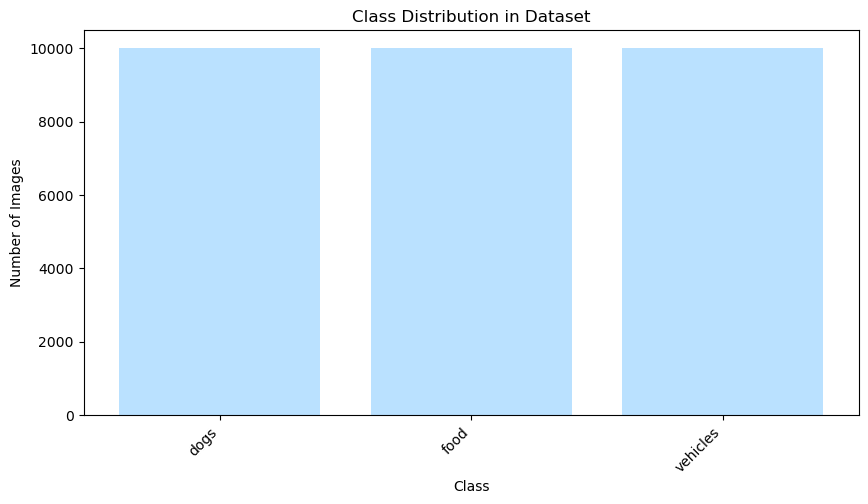

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8044444..2.3760502].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..1.367669].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].
Clippi

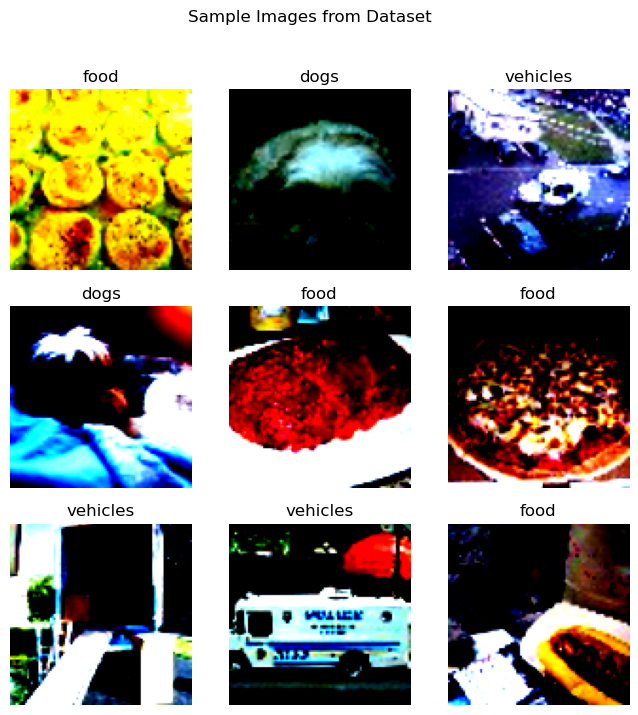

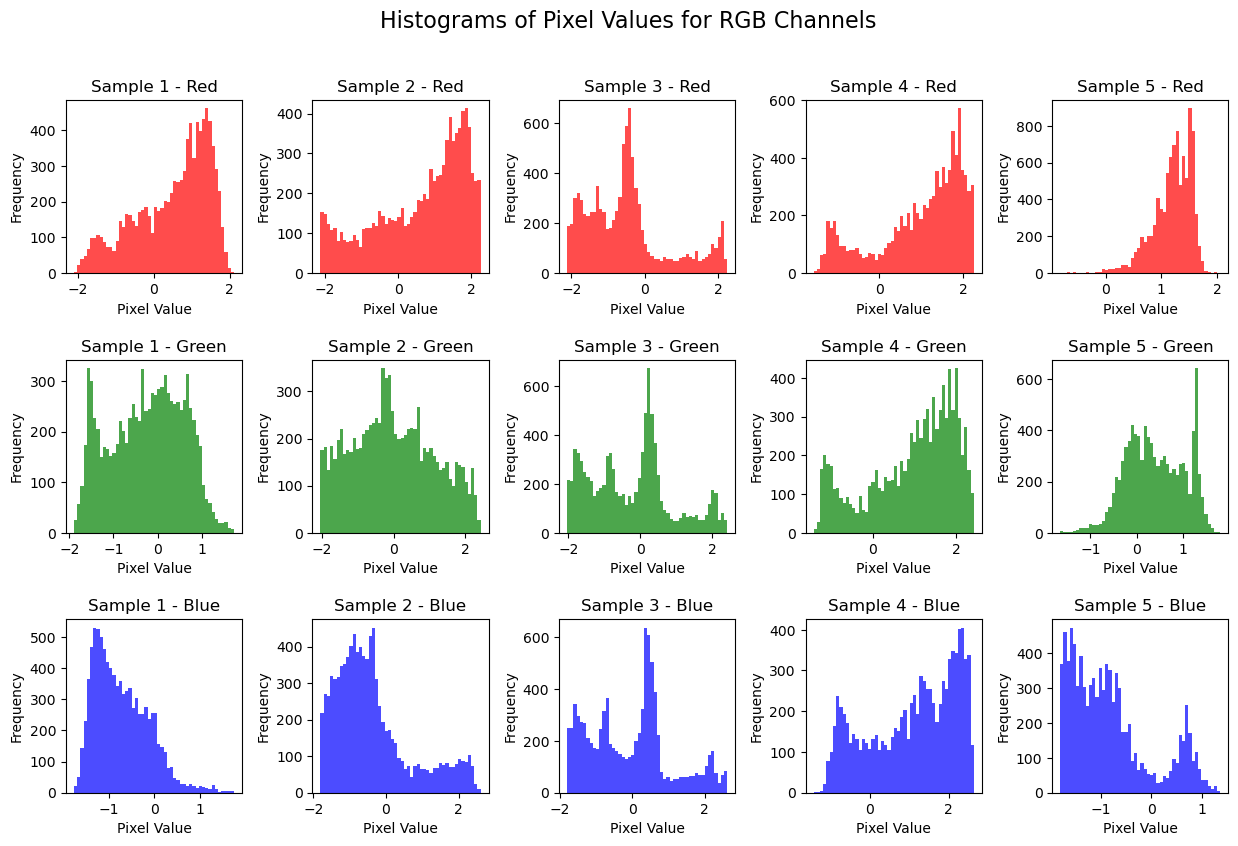

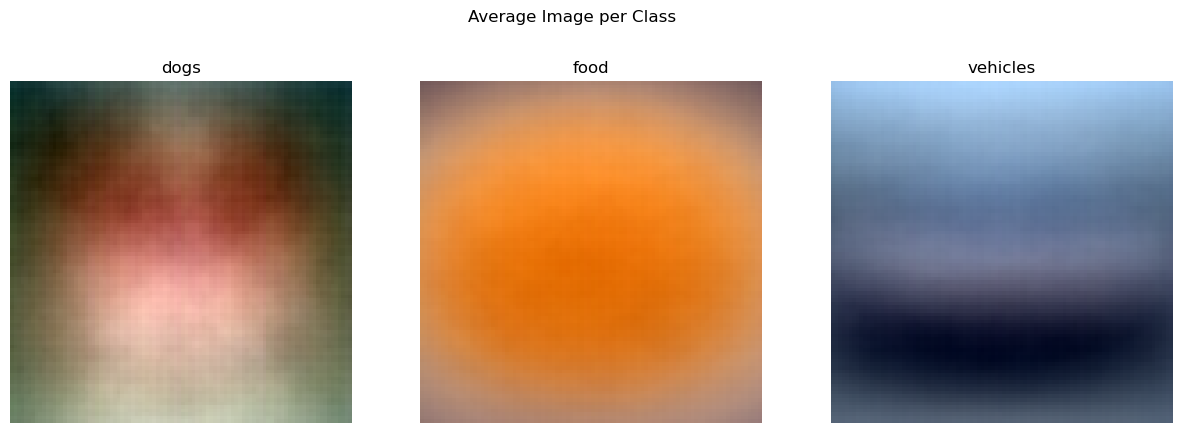

In [7]:
import random

plt.figure(figsize=(10, 5))
plt.bar(list(class_distribution.keys()), list(class_distribution.values()), color='#BAE1FF')
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Dataset")
plt.xticks(rotation = 45, ha="right")
plt.show()

# --------------------------------------------------------------------------------------------------------------------------------------------------------

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
fig.suptitle("Sample Images from Dataset")

for ax in axes.flatten():
    idx = random.randint(0, len(dataset) - 1)
    img, label = dataset[idx]
    img = img.permute(1, 2, 0)
    ax.imshow(img.numpy())
    ax.set_title(class_names[label])
    ax.axis("off")
plt.show()

# --------------------------------------------------------------------------------------------------------------------------------------------------------

num_samples = 5
sample_indices = random.sample(range(len(dataset)), num_samples)

fig, axes = plt.subplots(3, num_samples, figsize=(15, 9))
fig.suptitle("Histograms of Pixel Values for RGB Channels", fontsize=16)

channel_colors = ['red', 'green', 'blue']
channel_names = ['Red', 'Green', 'Blue']

for channel in range(3):
    for i, idx in enumerate(sample_indices):
        img, _ = dataset[idx]
        img = img.numpy()

        channel_data = img[channel].flatten()

        axes[channel, i].hist(channel_data, bins= 50, color = channel_colors[channel], alpha = 0.7)
        axes[channel, i].set_title(f"Sample {i+1} - {channel_names[channel]}")
        axes[channel, i].set_xlabel("Pixel Value")
        axes[channel, i].set_ylabel("Frequency")

plt.subplots_adjust(wspace = 0.4, hspace = 0.5)
plt.show()


# --------------------------------------------------------------------------------------------------------------------------------------------------------

class_average = {class_name: (class_sums[class_name] / class_distribution[class_name]) for class_name in class_names}
fig, axes = plt.subplots(1, len(class_names), figsize=(15, 5))
fig.suptitle("Average Image per Class")

for ax, cls in zip(axes, class_names):
    avg_img = class_average[cls].permute(1, 2, 0).numpy()
    avg_img = (avg_img - avg_img.min()) / (avg_img.max() - avg_img.min())

    ax.imshow(avg_img)
    ax.set_title(cls)
    ax.axis("off")

plt.show()


**Part 1 - Step 1 - Preprocessing about one-hot-encoding for target values**
- I tried to use one-hot-encoding for converting target value into the numerical format.

In [8]:
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

def create_one_hot_dataset(original_dataset, num_classes):
    images = []
    one_hot_labels = []
    
    for img, label in original_dataset:
        images.append(img)
        label_long = torch.tensor(label, dtype=torch.long)
        one_hot = F.one_hot(label_long, num_classes=num_classes)
        one_hot_labels.append(one_hot)
    
    images_tensor = torch.stack(images)
    labels_tensor = torch.stack(one_hot_labels)
    
    return TensorDataset(images_tensor, labels_tensor)


dataset = create_one_hot_dataset(dataset, num_classes=num_classes)
print(len(dataset))

30000


**Part 1 - Step 1 - To split the dataset into training, testing, and validation sets**  
- I split the dataset into test with 70%, validation with 15%, and test with 15% by using sklearn’s function.
- The each dataset was enveloped by Dataloder from Dataloader from pytorch for the efficient traning.

In [9]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

indices = list(range(len(dataset)))
train_indices, temp_indices = train_test_split(indices, test_size = 0.30, random_state = 42)
val_indices, test_indices = train_test_split(temp_indices, test_size = 0.50, random_state = 42)

train_dataset = Subset(dataset, train_indices)
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle=True, num_workers = 4)
val_dataset = Subset(dataset, val_indices)
val_loader = DataLoader(val_dataset, batch_size = 64,shuffle=False, num_workers = 4)
test_dataset = Subset(dataset, test_indices)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle=False, num_workers = 4)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Training set size: 21000
Validation set size: 4500
Test set size: 4500


## Step 2: Implementing VGG

**Part 1 - Step 2 - Implement the VGG-16 with Version C architecture & Training Fuction & Testing Function**

- VGG16C is a modified VGG16-based CNN designed for classification. It has features about five convolutional blocks that progressively increase the number of filters 64 -> 128 -> 256 -> 512 -> 512. Each block consists of multiple Conv2d layers with ReLU activation. And it is followed by max pooling for spatial downsampling. The get_flatten_size() function dynamically determines the input size for the classifier, which includes three fully connected layers 4096 -> 4096 -> num_classes with ReLU activation and dropout for regularization. The model supports Xavier or He initialization for weight optimization which ensures stable training dynamics
- I used Dropout with value 0.5 which can mean that 50% of the neurons in the fully connected layers are randomly dropped during training to prevent overfitting
- StepLR is selected as a scheduler for reducing the learning rate by defining gamma with 0.5 and step size with 5
- I can apply 3 methods for overfitting and regularization. Firstly, early stopping has been tried. It can make the model to stop when the model has no more progress in the defined count. On the next step, Batch Normalization can be seen in the VGG neural net class. Finally, a parameter like weight decay in optim library can prevent overfitting while applying L2 regularization.

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard.writer import SummaryWriter


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

class VGG16C(nn.Module):
    def __init__(self, num_classes = 3, init_type='xavier'):
        super(VGG16C, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 3, padding = 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size = 3, padding = 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),  

            nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size = 3, padding = 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),  

            nn.Conv2d(128, 256, kernel_size = 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size = 3, padding = 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size = 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size = 3, padding = 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),  

            nn.Conv2d(256, 512, kernel_size = 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size = 3, padding = 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size = 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size = 3, padding = 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),  

            nn.Conv2d(512, 512, kernel_size = 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size = 3, padding = 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size = 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size = 3, padding = 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),  
        )

        self.flatten_size = self.get_flatten_size()

        self.classifier = nn.Sequential(
            nn.Linear(self.flatten_size, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),
        )

        self.initialize_weights(init_type)

    def initialize_weights(self, init_type='xavier'):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                if init_type.lower() == 'xavier':
                    nn.init.xavier_normal_(m.weight)
                elif init_type.lower() == 'he':
                    nn.init.kaiming_normal_(m.weight, nonlinearity = 'relu')
                else:
                    pass
                
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def get_flatten_size(self):
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 96, 96)
            output = self.features(dummy_input)
            
            return output.view(1, -1).shape[1]

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x


# ------------------------------------------------------------------------------------------------------------
# Training and Testing -> Base without optimized version

def train_one_epoch_without_optimization(model, dataloader, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.argmax(dim=1).long()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def validate_without_optimization(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.argmax(dim=1).long()
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def train_model_without_optimization(model, train_loader, val_loader, num_epochs = 7, patience = 3, batch_size = 32):
    criterion = nn.CrossEntropyLoss()
    best_val_loss = float('inf')
    best_model_weights = None
    epochs_no_improve = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    writer = SummaryWriter(log_dir=f"runs/model_{batch_size}")
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch_without_optimization(model, train_loader, criterion)
        val_loss, val_acc = validate(model, val_loader, criterion)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if writer is not None:
            writer.add_scalar("Loss/train", train_loss, epoch)
            writer.add_scalar("Loss/validation", val_loss, epoch)
            writer.add_scalar("Accuracy/train", train_acc, epoch)
            writer.add_scalar("Accuracy/validation", val_acc, epoch)

        print(f"Epoch [{epoch + 1} of {num_epochs}]: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping")
                break
    
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)

    if writer is not None:
        print(f"Closing TensorBoard writer for {writer.log_dir}")
        writer.flush()
        writer.close()
    
    return model, history


def experiment_without_optimization(num_classes, batch_size = 32, num_epochs = 7):
    print(f"--- Model training with batch_size = {batch_size} ---")
    
    model = VGG16C(num_classes=num_classes).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
    scheduler = StepLR(optimizer, step_size = 5, gamma = 0.5)
    model, history = train_model_without_optimization(model, train_loader, val_loader, patience=3, batch_size=batch_size)
    test_loss, test_acc = validate_without_optimization(model, test_loader, nn.CrossEntropyLoss())

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    
    return model, history



# ------------------------------------------------------------------------------------------------------------
# Training and Testing -> Optimized version

learning_rate = 0.003
optimizers = {
    'SGD': lambda params: optim.SGD(params, lr = learning_rate, momentum=0.9, weight_decay = 1e-4),
    'Adam': lambda params: optim.Adam(params, lr = learning_rate, weight_decay = 1e-4),
    'AdamW': lambda params: optim.AdamW(params, lr = learning_rate, weight_decay = 1e-4),
    'RMSprop': lambda params: optim.RMSprop(params, lr = learning_rate, weight_decay =1e-4),
}

def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.argmax(dim=1).long()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def validate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.argmax(dim = 1).long()
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def train_model(model, train_loader, val_loader, optim, optim_str, scheduler = None, num_epochs = 10, patience = 3, init_type = 'he', batch_size = 32):
    criterion = nn.CrossEntropyLoss()
    best_val_loss = float('inf')
    best_model_weights = None
    epochs_no_improve = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [],'val_acc': []}
    writer = SummaryWriter(log_dir=f"runs/VGG16C_{init_type}_{optim_str}_{batch_size}")
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optim)
        val_loss, val_acc = validate(model, val_loader, criterion)
        
        if scheduler is not None:
            scheduler.step()
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if writer is not None:
            writer.add_scalar("Loss/train", train_loss, epoch)
            writer.add_scalar("Loss/validation", val_loss, epoch)
            writer.add_scalar("Accuracy/train", train_acc, epoch)
            writer.add_scalar("Accuracy/validation", val_acc, epoch)

        
        print(f"Epoch [{epoch + 1} of {num_epochs}]: " f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping")
                break
    
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)

    if writer is not None:
        print(f"Closing TensorBoard writer for {writer.log_dir}")
        writer.flush()
        writer.close()
    
    
    return model, history


def experiment(num_classes, init_type = 'xavier', optimizer_name='SGD', batch_size = 32, num_epochs = 10):
    print(f"--- VGG16-C with init = {init_type}, optimizer = {optimizer_name}, batch_size = {batch_size} ---")
    
    model = VGG16C(num_classes = num_classes, init_type = init_type).to(device)
    optimizer = optimizers[optimizer_name](model.parameters())
    scheduler = StepLR(optimizer, step_size = 5, gamma = 0.5)    
    model, history = train_model(model, train_loader, val_loader, scheduler = scheduler, num_epochs = num_epochs, patience = 3, init_type = init_type, 
                                 optim = optimizer, optim_str=optimizer_name, batch_size = batch_size)
    test_loss, test_acc = validate(model, test_loader, nn.CrossEntropyLoss())

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    
    return model, history

Using device: mps


**Part 1 - Step 2 - To define a functino drawing plot visualization for the model with specific parameters**

- To show misclassified images (Total 5 images)
- Confusion Matrix
- Other Matrix like precision and F1
- Plot graph to draw accuracy and loss for traning, validation

In [66]:
def get_model_performance(model, history):
    vgg_train_acc = history['train_acc']
    vgg_val_acc = history['val_acc']
    vgg_train_loss = history['train_loss']
    vgg_val_loss = history['val_loss']
    epochs = range(1, len(vgg_train_acc) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, vgg_train_acc, 'bo-', label = "Training Accuracy")
    plt.plot(epochs, vgg_val_acc, 'o-', color = 'brown', label = "Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.grid()
    plt.xticks(epochs)
    plt.show()


    plt.figure(figsize=(8, 5))
    plt.plot(epochs, vgg_train_loss, 'bo-', label = "Training Loss")
    plt.plot(epochs, vgg_val_loss, 'o-', color = 'brown', label = "Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid()
    plt.xticks(epochs)
    plt.show()

    # --------------------------------------------------------------------------------------------------------------------------------------------------------

    # Confusion Matrix
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.argmax(dim=1).cpu().numpy()
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)

    result = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(result, annot=True, fmt="d", cmap="Blues", xticklabels = [str(i) for i in range(num_classes)], yticklabels=[str(i) for i in range(num_classes)])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    # --------------------------------------------------------------------------------------------------------------------------------------------------------

    # Other Matrix like precision and F1
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    # --------------------------------------------------------------------------------------------------------------------------------------------------------

    # To show misclassified images (Total 5 images)
    misclassified = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.argmax(dim = 1)
            outputs = model(images)
            preds = torch.argmax(outputs, dim = 1)

            for img, pred, label in zip(images, preds, labels):
                if pred != label:
                    misclassified.append((img.cpu(), pred.cpu().item(), label.cpu().item()))
                
                if len(misclassified) >= 5:
                    break
            if len(misclassified) >= 5:
                break

    _, axes = plt.subplots(1, 5, figsize=(15, 5))

    for i, (img, pred, label) in enumerate(misclassified):
        img = img.permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"Pred: {class_names[pred]}\n True: {class_names[label]}")

    plt.show()

**Part 1 - Step 2 - Base Model Without Any Optimization(Parameter tuning)**

--- Model training with batch_size = 32 ---
Epoch [1 of 7]: Train Loss: 1.0986, Train Acc: 0.3304 | Val Loss: 1.0986, Val Acc: 0.3329
Epoch [2 of 7]: Train Loss: 1.0986, Train Acc: 0.3327 | Val Loss: 1.0986, Val Acc: 0.3329
Epoch [3 of 7]: Train Loss: 1.0986, Train Acc: 0.3305 | Val Loss: 1.0986, Val Acc: 0.3329
Epoch [4 of 7]: Train Loss: 1.0986, Train Acc: 0.3312 | Val Loss: 1.0986, Val Acc: 0.3329
Early stopping
Closing TensorBoard writer for runs/model_32
Test Loss: 1.0986, Test Accuracy: 0.3324


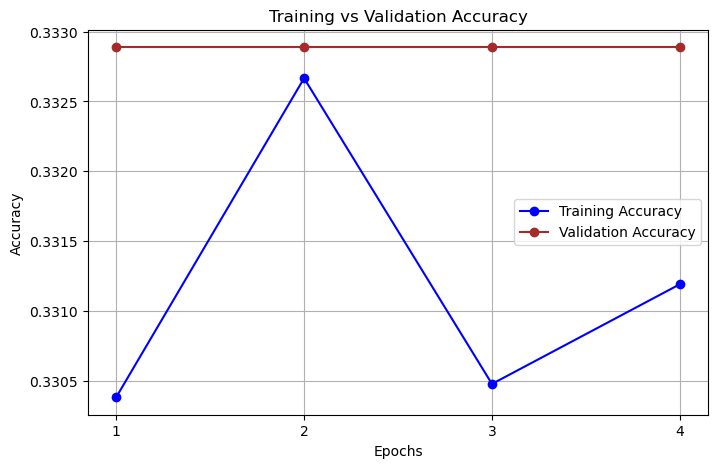

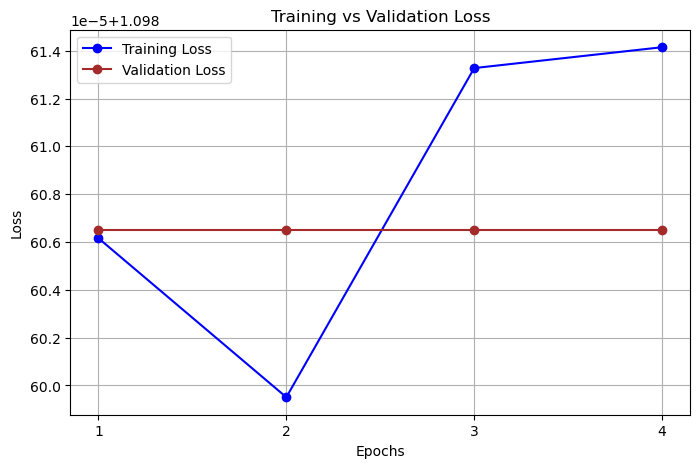

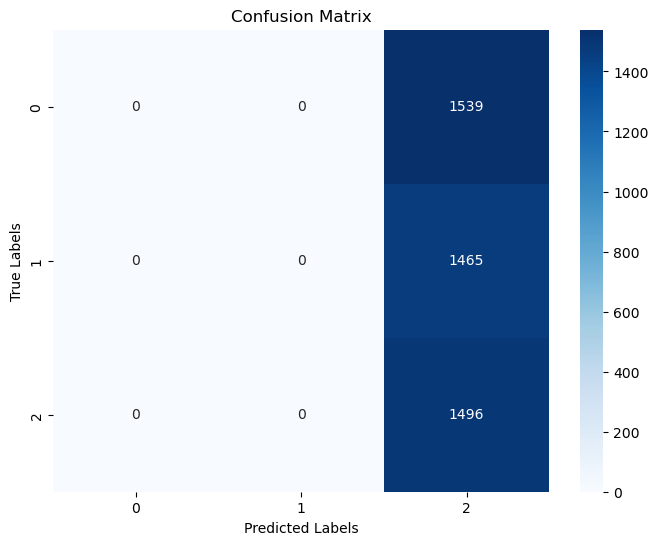

Precision: 0.1108
Recall: 0.3333
F1-score: 0.1663


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


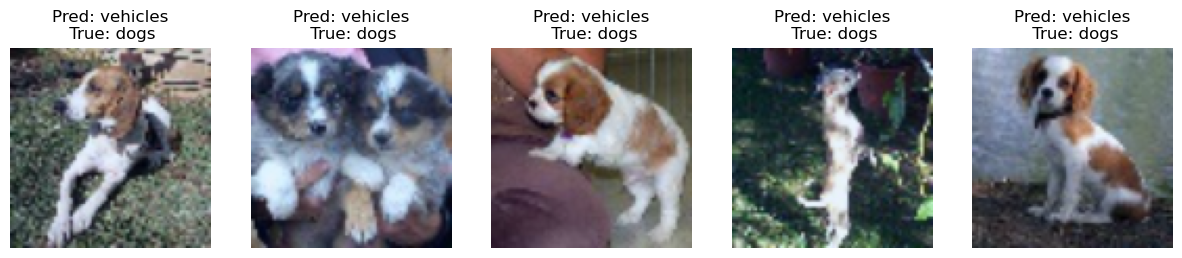

In [67]:
model0, history0 = experiment_without_optimization(num_classes = num_classes)
get_model_performance(model0, history0)

**The 12 combinations are tried for finding the best model case. The weight initializations consist of he and xavier. And SGD, Adam, and AdamW are used for optimizers. Finally, the batch sizes are 64 and 128. So I can compare 12 cases while applying parameter tuning utilizing this conditions.**

**Part 1 - Step 2 - Parameter Tuning Case 1**  
Weight init = 'xavier' / Optimizer = 'SGD' / Batch size = 64

- The more I try epochs, accuracy for training and validation tend to increase.
- The more I try epochs, loss for training and validation tend to decrease.
- This case classifies all of the classes well evenly.
- The model performs very well with high precision and recall indicating that it effectively classifies positive cases while minimizing both false positives and false negatives.
- Like the fourth case, when the image has two more objects, it is not easy to classify it correctly.

--- VGG16-C with init = xavier, optimizer = SGD, batch_size = 64 ---
Epoch [1 of 7]: Train Loss: 1.0868, Train Acc: 0.4328 | Val Loss: 0.9573, Val Acc: 0.5507
Epoch [2 of 7]: Train Loss: 0.7191, Train Acc: 0.6813 | Val Loss: 0.9652, Val Acc: 0.6078
Epoch [3 of 7]: Train Loss: 0.5049, Train Acc: 0.8004 | Val Loss: 0.4056, Val Acc: 0.8398
Epoch [4 of 7]: Train Loss: 0.4236, Train Acc: 0.8372 | Val Loss: 0.4359, Val Acc: 0.8207
Epoch [5 of 7]: Train Loss: 0.3917, Train Acc: 0.8509 | Val Loss: 0.3429, Val Acc: 0.8684
Epoch [6 of 7]: Train Loss: 0.3248, Train Acc: 0.8790 | Val Loss: 0.3848, Val Acc: 0.8529
Epoch [7 of 7]: Train Loss: 0.3084, Train Acc: 0.8871 | Val Loss: 0.3059, Val Acc: 0.8891
Closing TensorBoard writer for runs/VGG16C_xavier_SGD_64
Test Loss: 0.2944, Test Accuracy: 0.8871


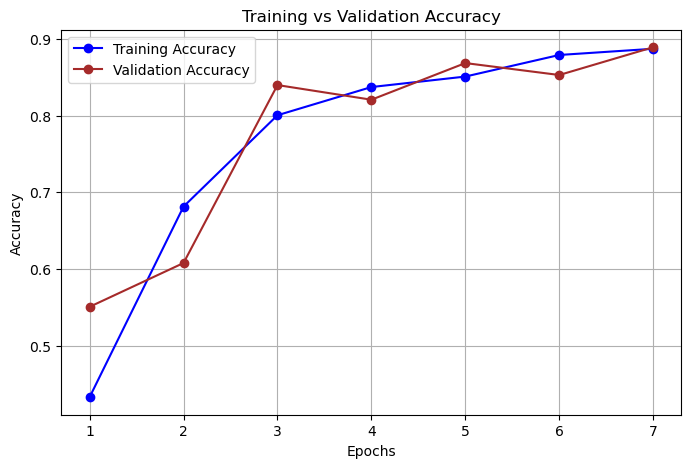

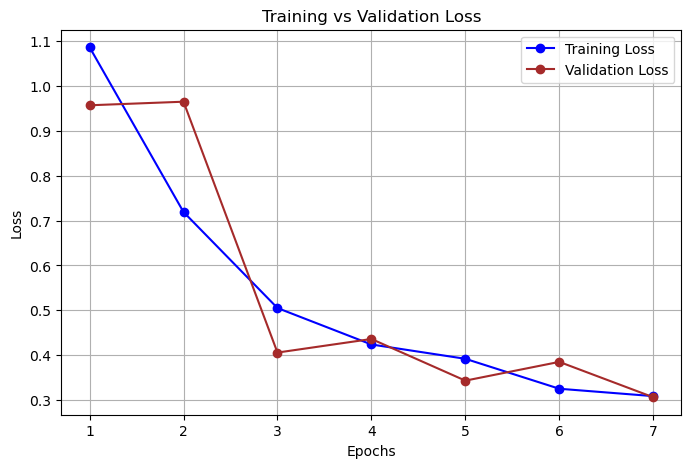

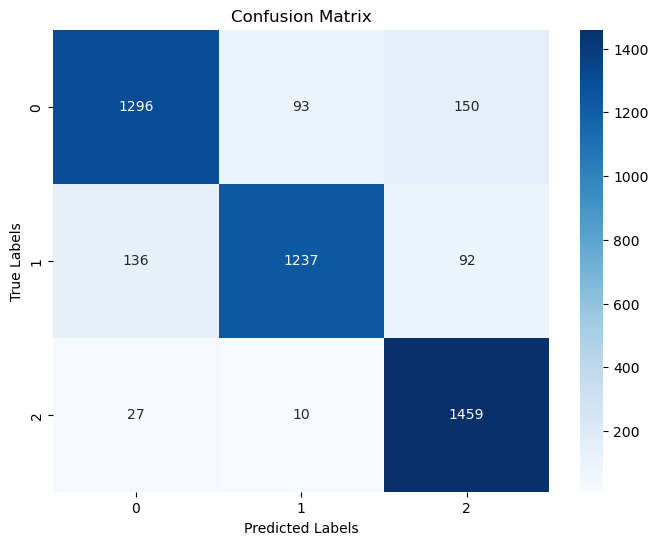

Precision: 0.8897
Recall: 0.8872
F1-score: 0.8864


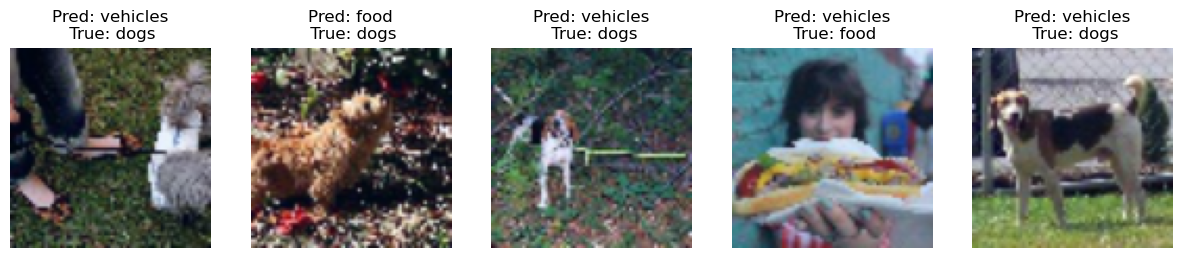

In [41]:
model1, history1 = experiment(num_classes = num_classes, init_type='xavier', optimizer_name = 'SGD', batch_size = 64, num_epochs = 7)
get_model_performance(model1, history1)

**Part 1 - Step 2 - Parameter Tuning Case 2**  
Weight init = 'xavier' / Optimizer = 'SGD' / Batch size = 128

--- VGG16-C with init = xavier, optimizer = SGD, batch_size = 128 ---
Epoch [1 of 7]: Train Loss: 1.0370, Train Acc: 0.4817 | Val Loss: 0.7449, Val Acc: 0.6533
Epoch [2 of 7]: Train Loss: 0.6785, Train Acc: 0.7050 | Val Loss: 0.4772, Val Acc: 0.8069
Epoch [3 of 7]: Train Loss: 0.4932, Train Acc: 0.8002 | Val Loss: 0.5171, Val Acc: 0.7884
Epoch [4 of 7]: Train Loss: 0.4544, Train Acc: 0.8190 | Val Loss: 0.4059, Val Acc: 0.8369
Epoch [5 of 7]: Train Loss: 0.4001, Train Acc: 0.8439 | Val Loss: 0.3958, Val Acc: 0.8520
Epoch [6 of 7]: Train Loss: 0.3500, Train Acc: 0.8669 | Val Loss: 0.3337, Val Acc: 0.8718
Epoch [7 of 7]: Train Loss: 0.3445, Train Acc: 0.8709 | Val Loss: 0.3303, Val Acc: 0.8693
Closing TensorBoard writer for runs/VGG16C_xavier_SGD_128
Test Loss: 0.3204, Test Accuracy: 0.8713


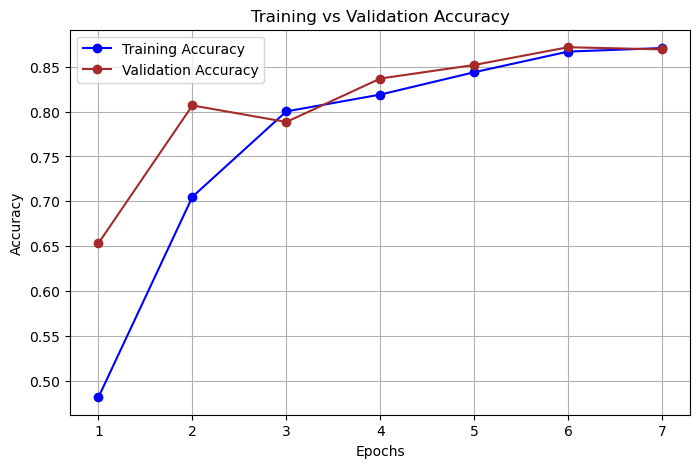

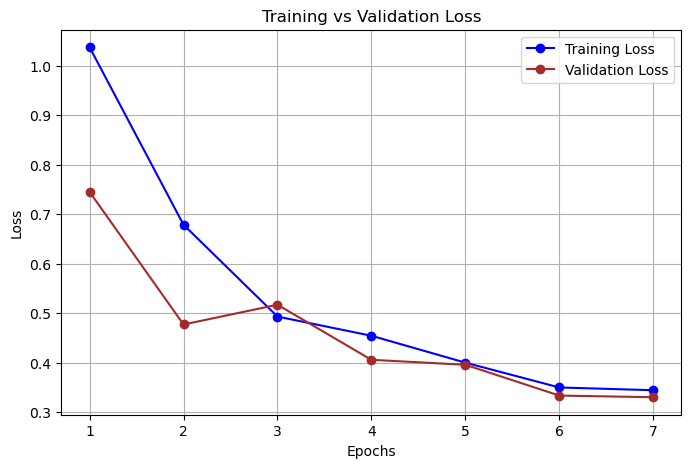

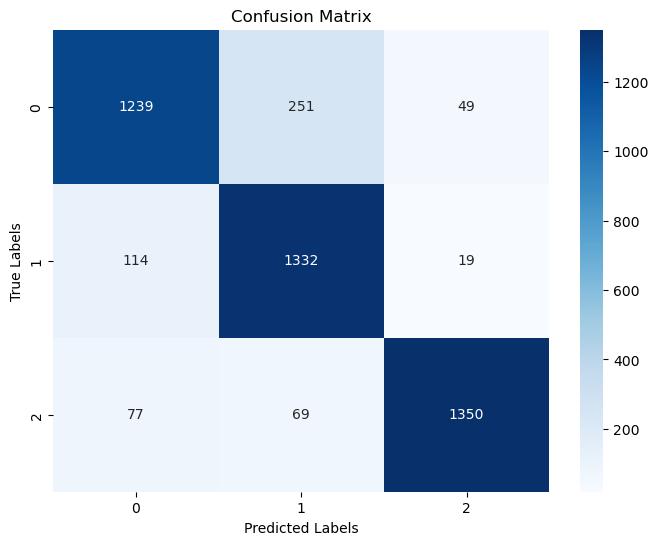

Precision: 0.8749
Recall: 0.8722
F1-score: 0.8720


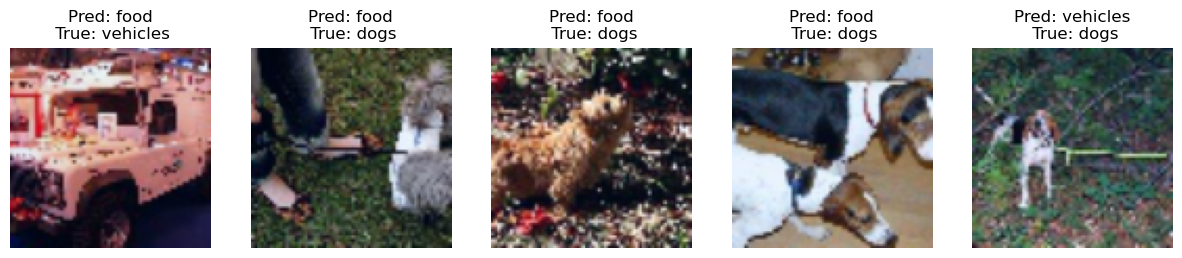

In [42]:
model2, history2 = experiment(num_classes = num_classes, init_type='xavier', optimizer_name = 'SGD', batch_size = 128, num_epochs = 7)
get_model_performance(model2, history2)

**Part 1 - Step 2 - Parameter Tuning Case 3**  
Weight init = 'he' / Optimizer = 'SGD' / Batch size = 64

--- VGG16-C with init = he, optimizer = SGD, batch_size = 64 ---
Epoch [1 of 7]: Train Loss: 0.9297, Train Acc: 0.6313 | Val Loss: 0.5241, Val Acc: 0.7944
Epoch [2 of 7]: Train Loss: 0.4869, Train Acc: 0.8055 | Val Loss: 0.4889, Val Acc: 0.8038
Epoch [3 of 7]: Train Loss: 0.4102, Train Acc: 0.8405 | Val Loss: 0.3611, Val Acc: 0.8629
Epoch [4 of 7]: Train Loss: 0.3734, Train Acc: 0.8557 | Val Loss: 0.3178, Val Acc: 0.8796
Epoch [5 of 7]: Train Loss: 0.3146, Train Acc: 0.8808 | Val Loss: 0.3009, Val Acc: 0.8864
Epoch [6 of 7]: Train Loss: 0.2601, Train Acc: 0.9024 | Val Loss: 0.2527, Val Acc: 0.9093
Epoch [7 of 7]: Train Loss: 0.2501, Train Acc: 0.9067 | Val Loss: 0.2667, Val Acc: 0.9047
Closing TensorBoard writer for runs/VGG16C_he_SGD_64
Test Loss: 0.2432, Test Accuracy: 0.9149


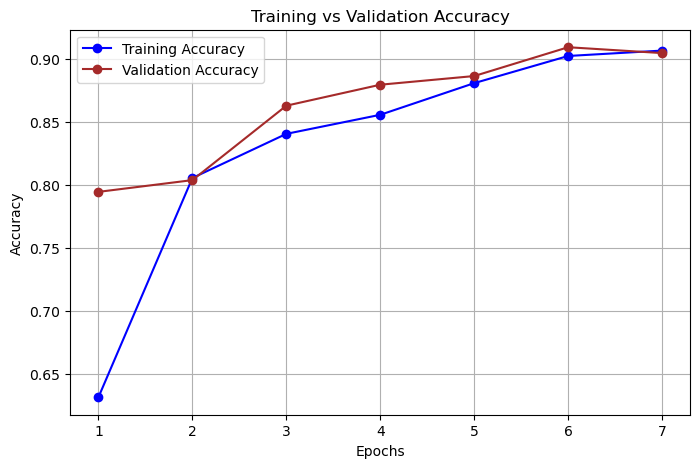

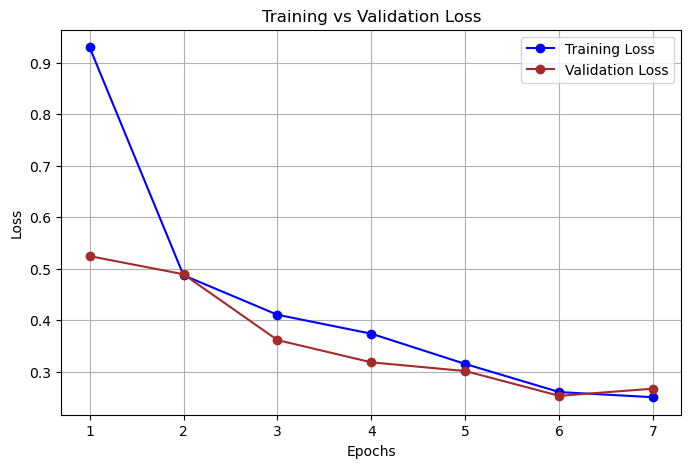

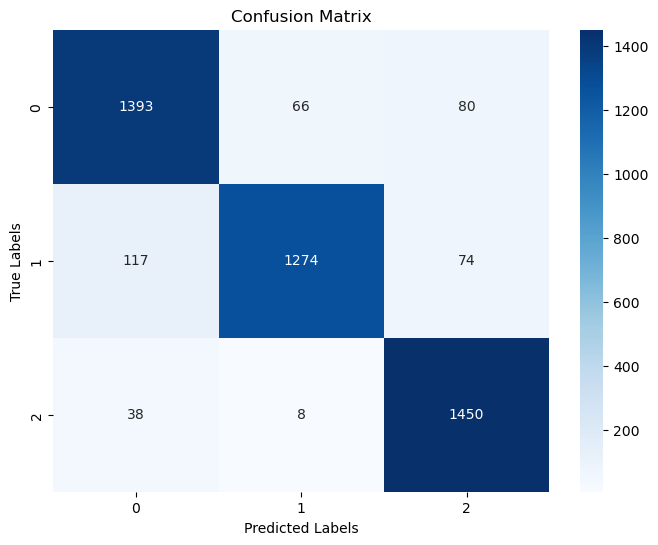

Precision: 0.9163
Recall: 0.9147
F1-score: 0.9146


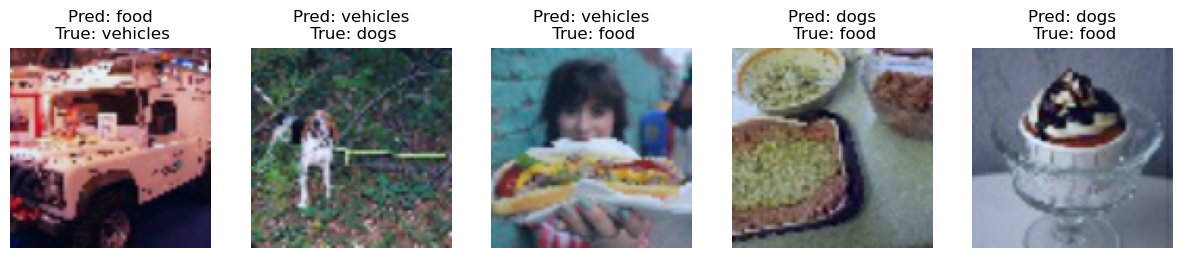

In [18]:
model3, history3 = experiment(num_classes = num_classes, init_type = 'he', optimizer_name = 'SGD', batch_size = 64, num_epochs = 7)
get_model_performance(model3, history3)

**Part 1 - Step 2 - Parameter Tuning Case 4**  
Weight init = 'he' / Optimizer = 'SGD' / Batch size = 128

--- VGG16-C with init = he, optimizer = SGD, batch_size = 128 ---
Epoch [1 of 7]: Train Loss: 0.7774, Train Acc: 0.6815 | Val Loss: 0.5175, Val Acc: 0.8051
Epoch [2 of 7]: Train Loss: 0.4550, Train Acc: 0.8238 | Val Loss: 0.5229, Val Acc: 0.8047
Epoch [3 of 7]: Train Loss: 0.3885, Train Acc: 0.8542 | Val Loss: 0.3251, Val Acc: 0.8842
Epoch [4 of 7]: Train Loss: 0.3241, Train Acc: 0.8814 | Val Loss: 0.3572, Val Acc: 0.8747
Epoch [5 of 7]: Train Loss: 0.3171, Train Acc: 0.8814 | Val Loss: 0.2674, Val Acc: 0.9040
Epoch [6 of 7]: Train Loss: 0.2524, Train Acc: 0.9071 | Val Loss: 0.2440, Val Acc: 0.9111
Epoch [7 of 7]: Train Loss: 0.2428, Train Acc: 0.9120 | Val Loss: 0.2584, Val Acc: 0.9042
Closing TensorBoard writer for runs/VGG16C_he_SGD_128
Test Loss: 0.2537, Test Accuracy: 0.9011


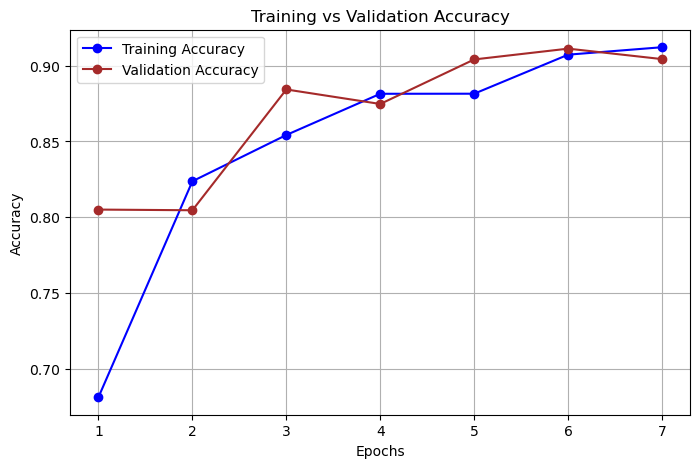

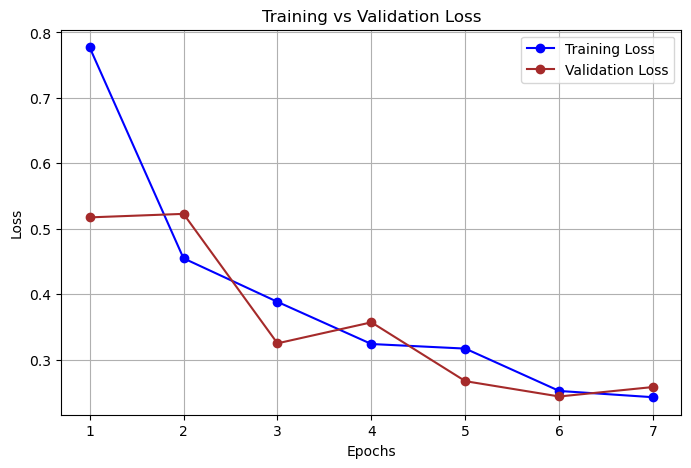

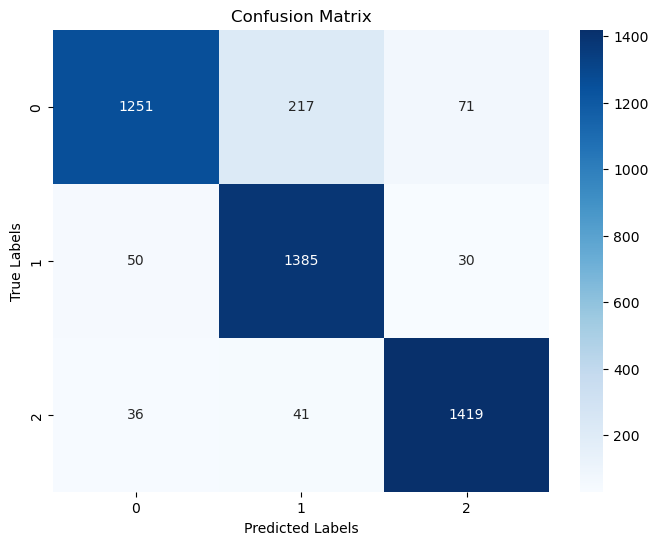

Precision: 0.9041
Recall: 0.9023
F1-score: 0.9007


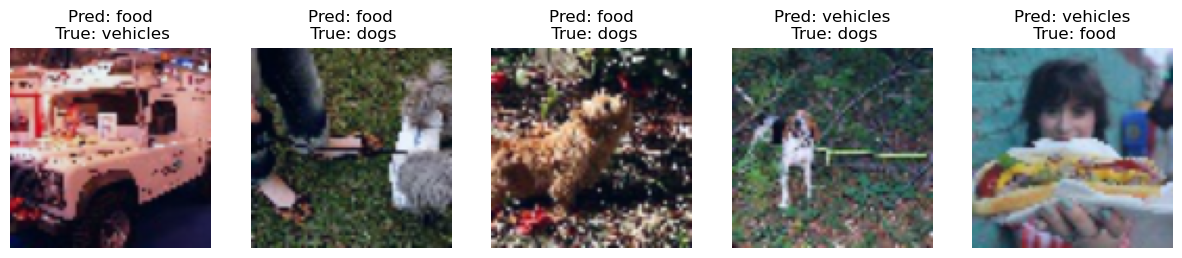

In [19]:
model4, history4 = experiment(num_classes = num_classes, init_type='he', optimizer_name = 'SGD', batch_size = 128, num_epochs = 7)
get_model_performance(model4, history4)

**Part 1 - Step 2 - Parameter Tuning Case 5**  
Weight init = 'he' / Optimizer = 'Adam' / Batch size = 64

- Using Adam optimizer can lead to accuracies under 40% and not bad loss.
- Adam's adaptive learning rate can lead to suboptimal convergence
- Adam dynamically adjusts the learning rate per parameter and sometimes lead to instability in deep networks like VGG
-  Adam's fast initial convergence can result in poor generalization. Conversely, SGD tends to achieve better final performance by allowing the model to settle into a more optimal minima

--- VGG16-C with init = he, optimizer = Adam, batch_size = 64 ---
Epoch [1 of 7]: Train Loss: 412.1924, Train Acc: 0.3804 | Val Loss: 1.0988, Val Acc: 0.3264
Epoch [2 of 7]: Train Loss: 1.1002, Train Acc: 0.3357 | Val Loss: 1.0985, Val Acc: 0.3407
Epoch [3 of 7]: Train Loss: 1.1639, Train Acc: 0.3332 | Val Loss: 1.1022, Val Acc: 0.3264
Epoch [4 of 7]: Train Loss: 1.4387, Train Acc: 0.3334 | Val Loss: 1.0995, Val Acc: 0.3329
Epoch [5 of 7]: Train Loss: 1.0992, Train Acc: 0.3353 | Val Loss: 1.0991, Val Acc: 0.3264
Early stopping
Closing TensorBoard writer for runs/VGG16C_he_Adam_64
Test Loss: 1.0985, Test Accuracy: 0.3420


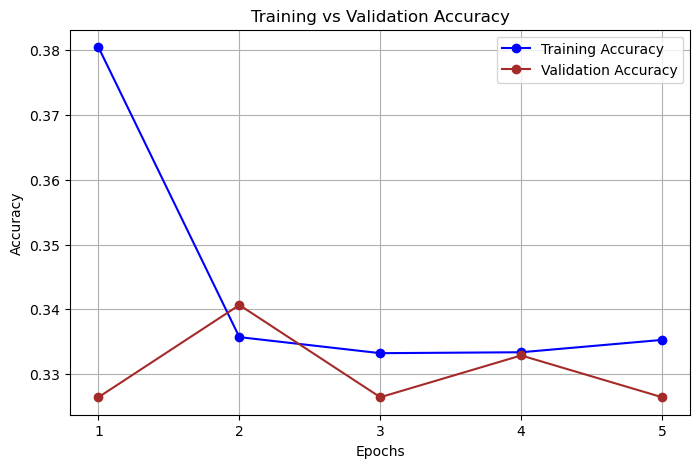

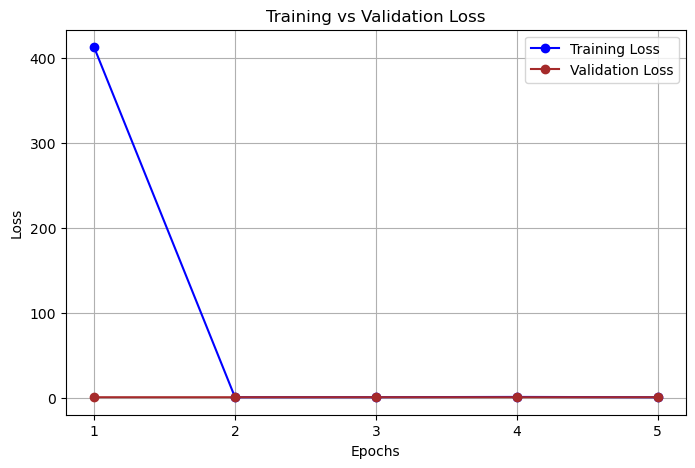

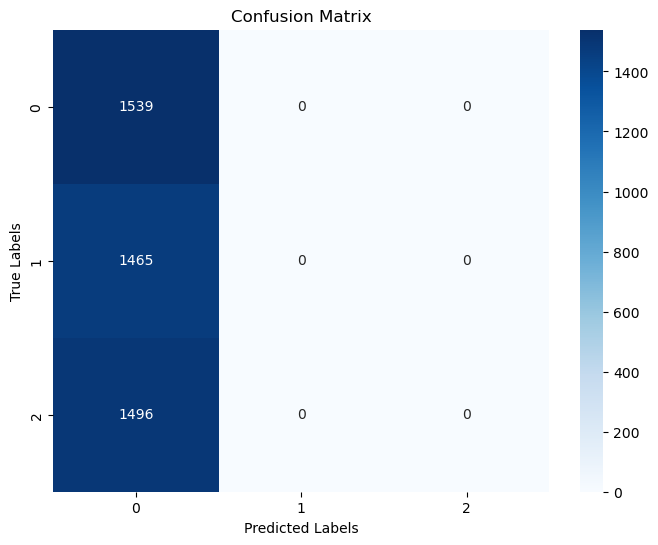

Precision: 0.1140
Recall: 0.3333
F1-score: 0.1699


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


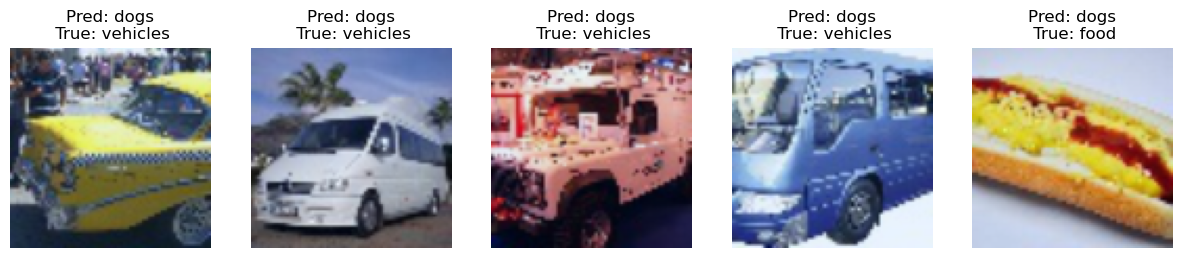

In [20]:
model5, history5 = experiment(num_classes = num_classes, init_type='he', optimizer_name = 'Adam', batch_size = 64, num_epochs = 7)
get_model_performance(model5, history5)

**Part 1 - Step 2 - Parameter Tuning Case 6**  
Weight init = 'he' / Optimizer = 'Adam' / Batch size = 128

--- VGG16-C with init = he, optimizer = Adam, batch_size = 128 ---
Epoch [1 of 7]: Train Loss: 137.1632, Train Acc: 0.4947 | Val Loss: 0.8271, Val Acc: 0.6356
Epoch [2 of 7]: Train Loss: 0.6492, Train Acc: 0.7255 | Val Loss: 0.5859, Val Acc: 0.7709
Epoch [3 of 7]: Train Loss: 0.5759, Train Acc: 0.7717 | Val Loss: 0.5555, Val Acc: 0.7664
Epoch [4 of 7]: Train Loss: 0.5109, Train Acc: 0.8005 | Val Loss: 0.5726, Val Acc: 0.7884
Epoch [5 of 7]: Train Loss: 0.4748, Train Acc: 0.8144 | Val Loss: 0.4698, Val Acc: 0.8093
Epoch [6 of 7]: Train Loss: 0.4053, Train Acc: 0.8420 | Val Loss: 0.4184, Val Acc: 0.8447
Epoch [7 of 7]: Train Loss: 0.3814, Train Acc: 0.8542 | Val Loss: 0.6526, Val Acc: 0.7478
Closing TensorBoard writer for runs/VGG16C_he_Adam_128
Test Loss: 0.6755, Test Accuracy: 0.7384


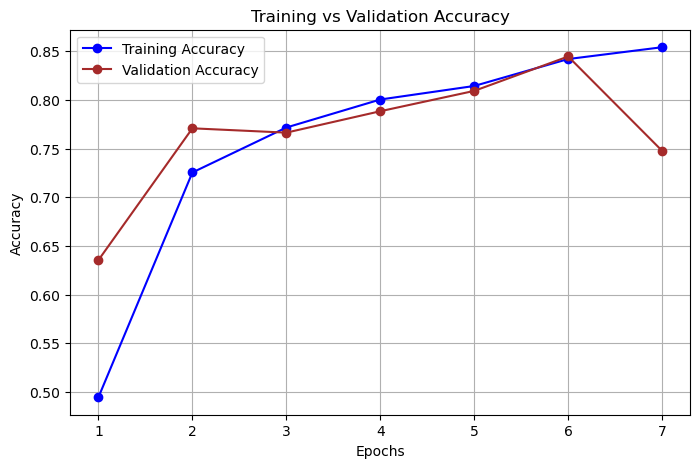

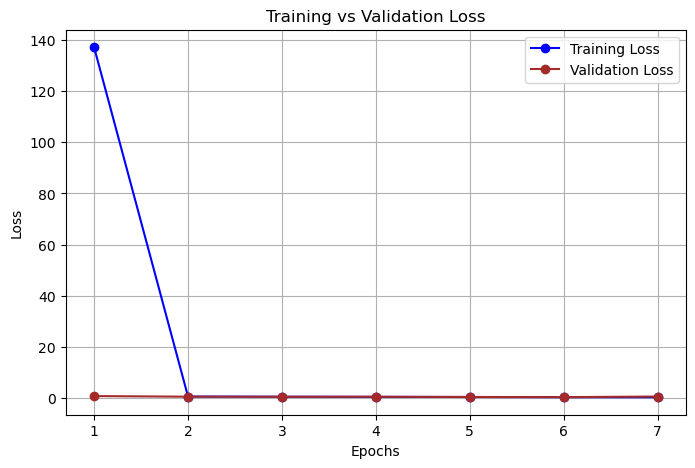

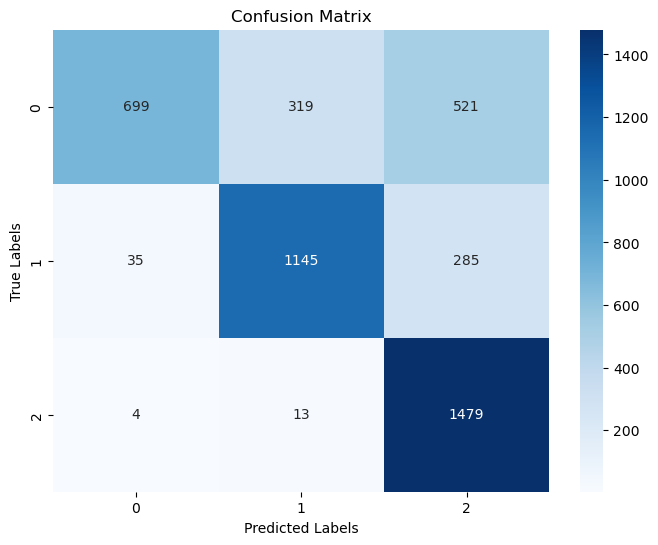

Precision: 0.7899
Recall: 0.7415
F1-score: 0.7249


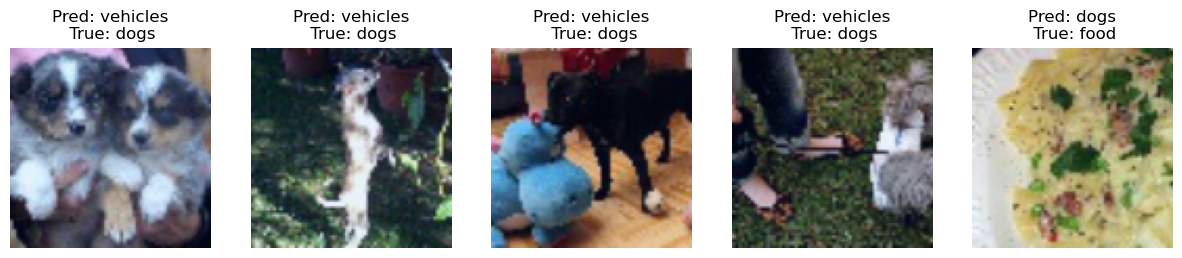

In [21]:
model6, history6 = experiment(num_classes = num_classes, init_type='he', optimizer_name = 'Adam', batch_size = 128, num_epochs = 7)
get_model_performance(model6, history6)

**Part 1 - Step 2 - Parameter Tuning Case 7**  
Weight init = 'he' / Optimizer = 'AdamW' / Batch size = 64

--- VGG16-C with init = he, optimizer = AdamW, batch_size = 64 ---
Epoch [1 of 7]: Train Loss: 971.9388, Train Acc: 0.4406 | Val Loss: 1.0253, Val Acc: 0.4896
Epoch [2 of 7]: Train Loss: 0.7757, Train Acc: 0.6660 | Val Loss: 0.6607, Val Acc: 0.7273
Epoch [3 of 7]: Train Loss: 0.6339, Train Acc: 0.7419 | Val Loss: 0.6081, Val Acc: 0.7482
Epoch [4 of 7]: Train Loss: 0.5343, Train Acc: 0.7901 | Val Loss: 0.6988, Val Acc: 0.7304
Epoch [5 of 7]: Train Loss: 0.4778, Train Acc: 0.8213 | Val Loss: 0.4420, Val Acc: 0.8329
Epoch [6 of 7]: Train Loss: 0.3980, Train Acc: 0.8496 | Val Loss: 0.4455, Val Acc: 0.8329
Epoch [7 of 7]: Train Loss: 0.3724, Train Acc: 0.8612 | Val Loss: 0.3538, Val Acc: 0.8691
Closing TensorBoard writer for runs/VGG16C_he_AdamW_64
Test Loss: 0.3474, Test Accuracy: 0.8682


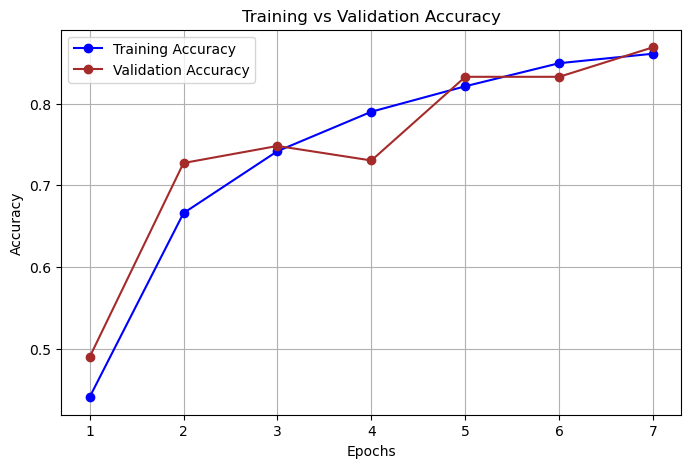

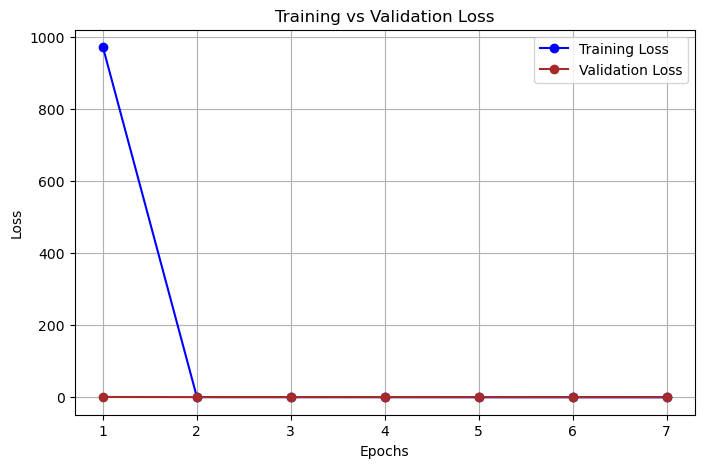

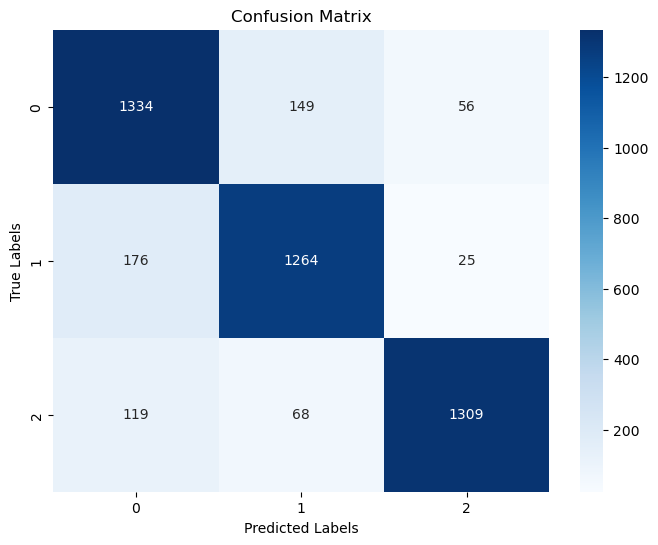

Precision: 0.8714
Recall: 0.8682
F1-score: 0.8691


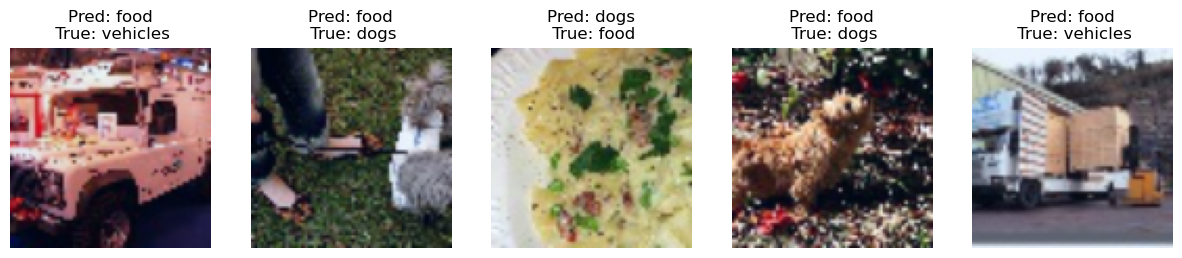

In [22]:
model7, history7 = experiment(num_classes = num_classes, init_type='he', optimizer_name = 'AdamW', batch_size = 64, num_epochs = 7)
get_model_performance(model7, history7)

**Part 1 - Step 2 - Parameter Tuning Case 8**  
Weight init = 'he' / Optimizer = 'AdamW' / Batch size = 128

--- VGG16-C with init = he, optimizer = AdamW, batch_size = 128 ---
Epoch [1 of 7]: Train Loss: 583.9908, Train Acc: 0.3369 | Val Loss: 1.1003, Val Acc: 0.3329
Epoch [2 of 7]: Train Loss: 1.0993, Train Acc: 0.3323 | Val Loss: 1.0986, Val Acc: 0.3329
Epoch [3 of 7]: Train Loss: 1.0990, Train Acc: 0.3321 | Val Loss: 1.0990, Val Acc: 0.3264
Epoch [4 of 7]: Train Loss: 1.0990, Train Acc: 0.3316 | Val Loss: 1.0995, Val Acc: 0.3264
Epoch [5 of 7]: Train Loss: 1.0988, Train Acc: 0.3312 | Val Loss: 1.0992, Val Acc: 0.3329
Early stopping
Closing TensorBoard writer for runs/VGG16C_he_AdamW_128
Test Loss: 1.0990, Test Accuracy: 0.3324


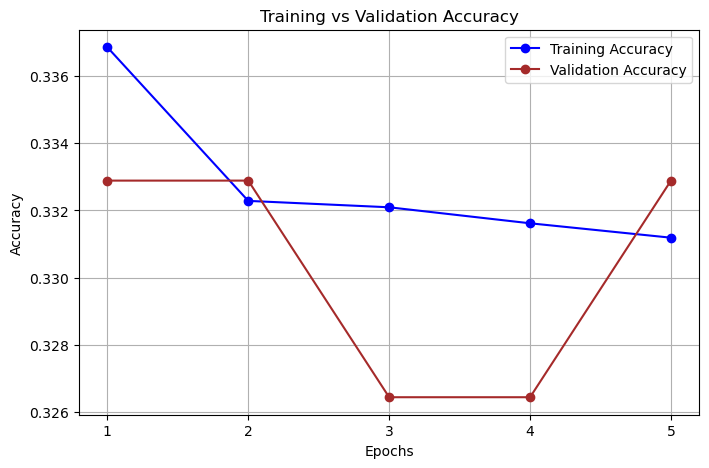

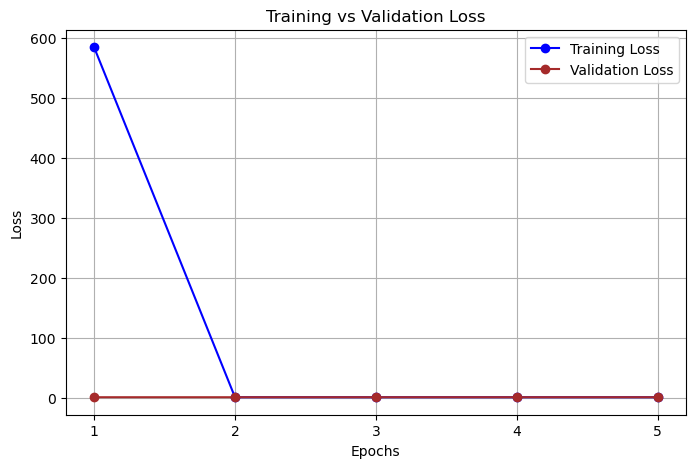

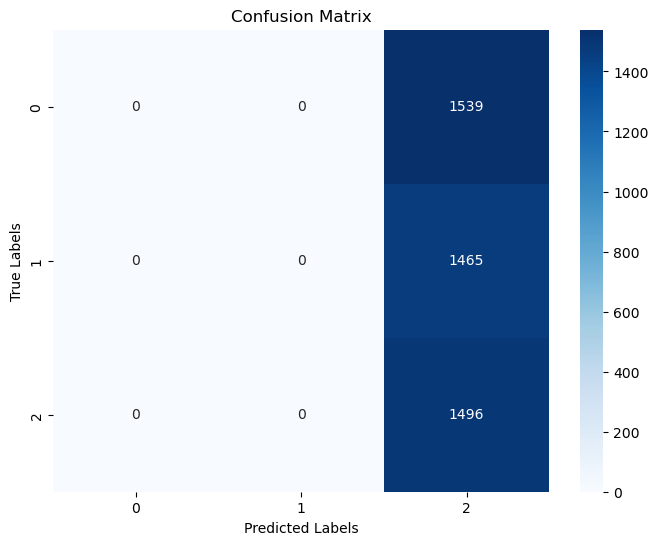

Precision: 0.1108
Recall: 0.3333
F1-score: 0.1663


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


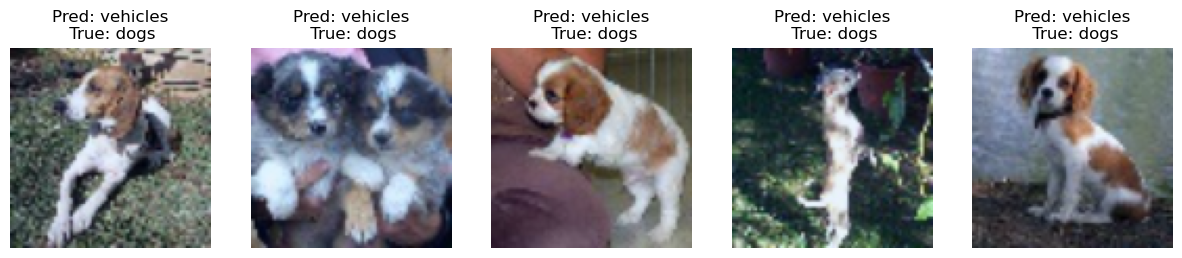

In [23]:
model8, history8 = experiment(num_classes = num_classes, init_type='he', optimizer_name = 'AdamW', batch_size = 128, num_epochs = 7)
get_model_performance(model8, history8)

**Part 1 - Step 2 - Parameter Tuning Case 9**  
Weight init = 'xavier' / Optimizer = 'AdamW' / Batch size = 64

--- VGG16-C with init = xavier, optimizer = AdamW, batch_size = 64 ---
Epoch [1 of 7]: Train Loss: 80.3633, Train Acc: 0.3440 | Val Loss: 1.0978, Val Acc: 0.3636
Epoch [2 of 7]: Train Loss: 1.3215, Train Acc: 0.3353 | Val Loss: 1.0988, Val Acc: 0.3264
Epoch [3 of 7]: Train Loss: 1.0993, Train Acc: 0.3337 | Val Loss: 1.0987, Val Acc: 0.3407
Epoch [4 of 7]: Train Loss: 1.0990, Train Acc: 0.3337 | Val Loss: 1.0985, Val Acc: 0.3407
Early stopping
Closing TensorBoard writer for runs/VGG16C_xavier_AdamW_64
Test Loss: 1.0987, Test Accuracy: 0.3256


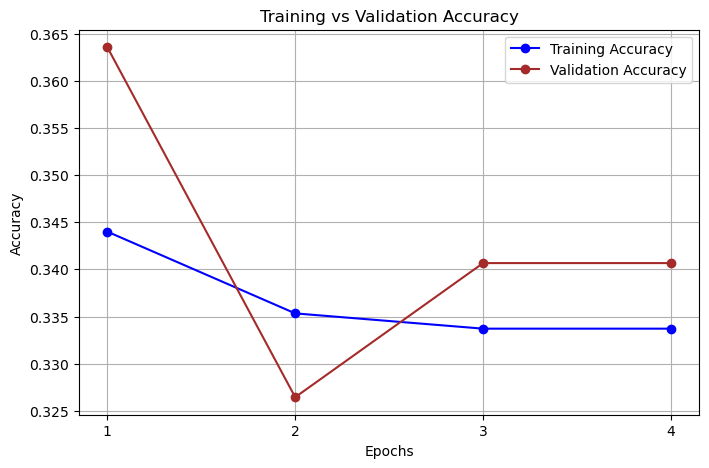

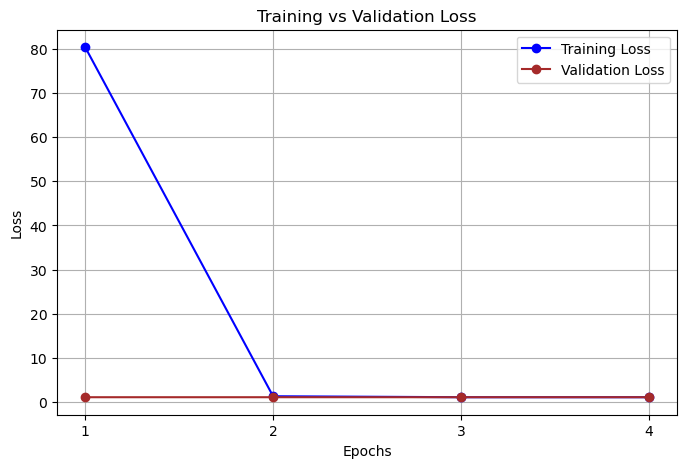

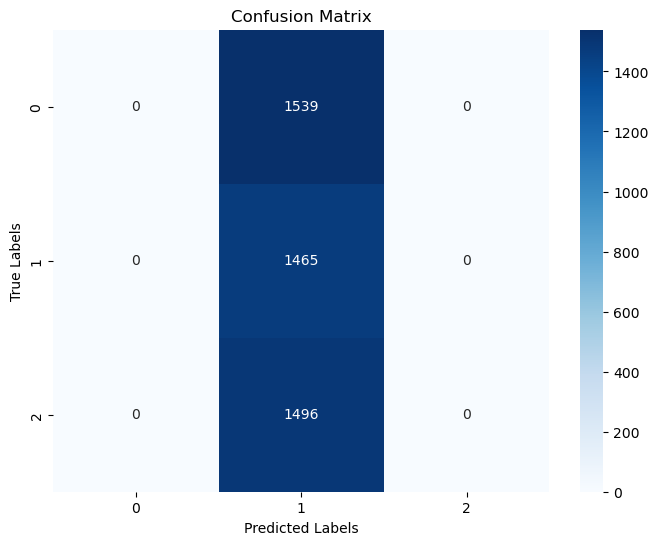

Precision: 0.1085
Recall: 0.3333
F1-score: 0.1637


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


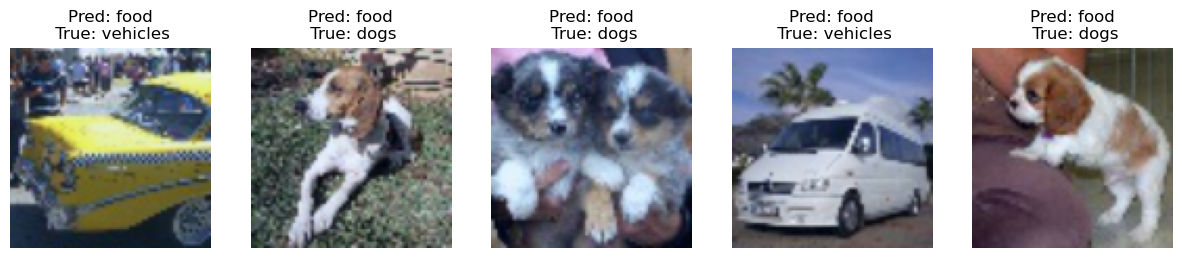

In [24]:
model9, history9 = experiment(num_classes = num_classes, init_type='xavier', optimizer_name = 'AdamW', batch_size = 64, num_epochs = 7)
get_model_performance(model9, history9)

**Part 1 - Step 2 - Parameter Tuning Case 10**  
Weight init = 'xavier' / Optimizer = 'AdamW' / Batch size = 128

--- VGG16-C with init = xavier, optimizer = AdamW, batch_size = 128 ---
Epoch [1 of 7]: Train Loss: 10.7211, Train Acc: 0.3344 | Val Loss: 1.0988, Val Acc: 0.3264
Epoch [2 of 7]: Train Loss: 1.0994, Train Acc: 0.3300 | Val Loss: 1.0986, Val Acc: 0.3329
Epoch [3 of 7]: Train Loss: 1.0989, Train Acc: 0.3338 | Val Loss: 1.0989, Val Acc: 0.3264
Epoch [4 of 7]: Train Loss: 1.0989, Train Acc: 0.3361 | Val Loss: 1.0985, Val Acc: 0.3407
Epoch [5 of 7]: Train Loss: 1.0989, Train Acc: 0.3330 | Val Loss: 1.0986, Val Acc: 0.3407
Epoch [6 of 7]: Train Loss: 1.0988, Train Acc: 0.3307 | Val Loss: 1.0986, Val Acc: 0.3407
Epoch [7 of 7]: Train Loss: 1.0987, Train Acc: 0.3345 | Val Loss: 1.0985, Val Acc: 0.3407
Early stopping
Closing TensorBoard writer for runs/VGG16C_xavier_AdamW_128
Test Loss: 1.0988, Test Accuracy: 0.3256


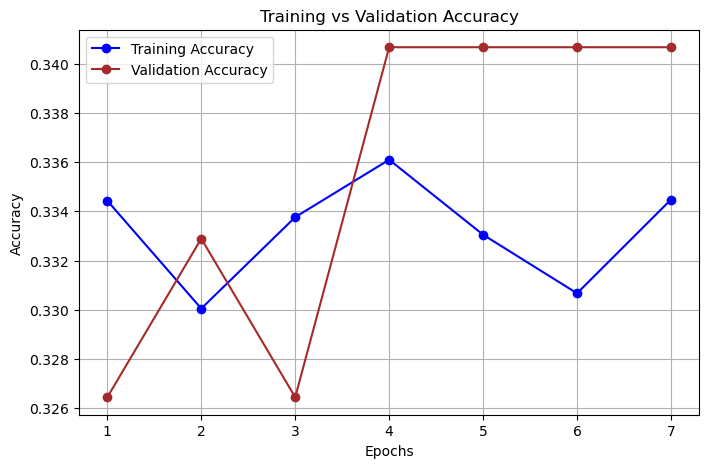

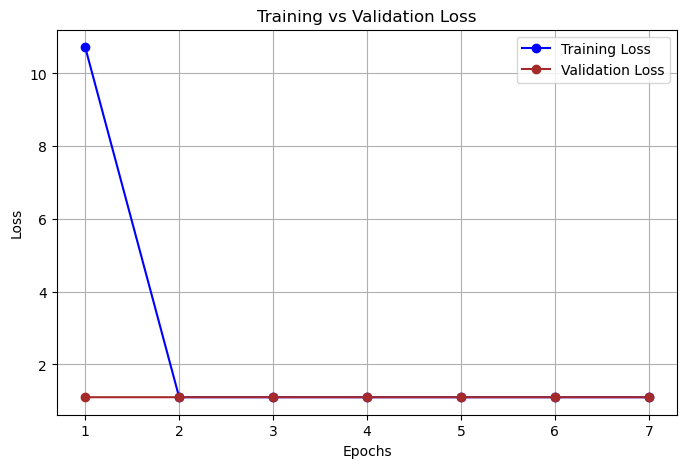

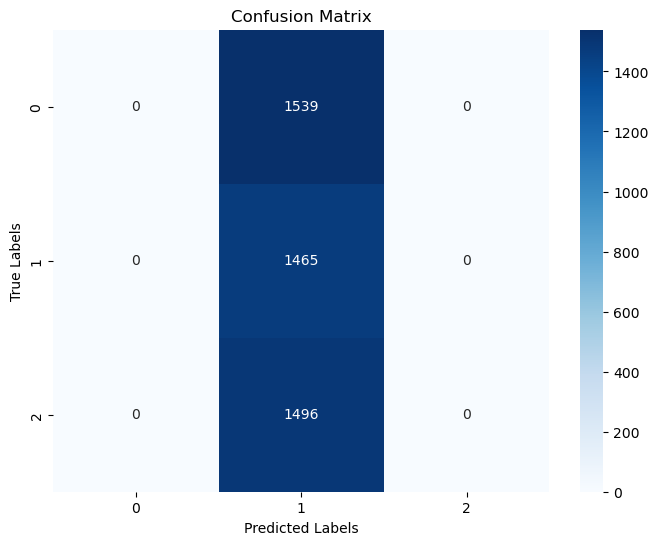

Precision: 0.1085
Recall: 0.3333
F1-score: 0.1637


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


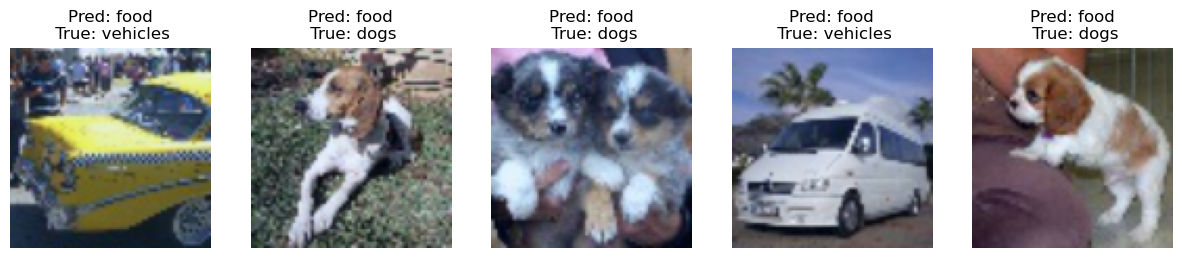

In [25]:
model10, history10 = experiment(num_classes = num_classes, init_type='xavier', optimizer_name = 'AdamW', batch_size = 128, num_epochs = 7)
get_model_performance(model10, history10)

**Part 1 - Step 2 - Parameter Tuning Case 11**  
Weight init = 'xavier' / Optimizer = 'Adam' / Batch size = 64

--- VGG16-C with init = xavier, optimizer = Adam, batch_size = 64 ---
Epoch [1 of 7]: Train Loss: 15.8281, Train Acc: 0.3329 | Val Loss: 1.0993, Val Acc: 0.3329
Epoch [2 of 7]: Train Loss: 1.0996, Train Acc: 0.3255 | Val Loss: 1.0990, Val Acc: 0.3264
Epoch [3 of 7]: Train Loss: 1.0997, Train Acc: 0.3310 | Val Loss: 1.0994, Val Acc: 0.3264
Epoch [4 of 7]: Train Loss: 1.0993, Train Acc: 0.3303 | Val Loss: 1.0993, Val Acc: 0.3329
Epoch [5 of 7]: Train Loss: 1.0994, Train Acc: 0.3278 | Val Loss: 1.0986, Val Acc: 0.3407
Epoch [6 of 7]: Train Loss: 1.0990, Train Acc: 0.3281 | Val Loss: 1.0987, Val Acc: 0.3329
Epoch [7 of 7]: Train Loss: 1.0988, Train Acc: 0.3318 | Val Loss: 1.0989, Val Acc: 0.3264
Closing TensorBoard writer for runs/VGG16C_xavier_Adam_64
Test Loss: 1.0985, Test Accuracy: 0.3420


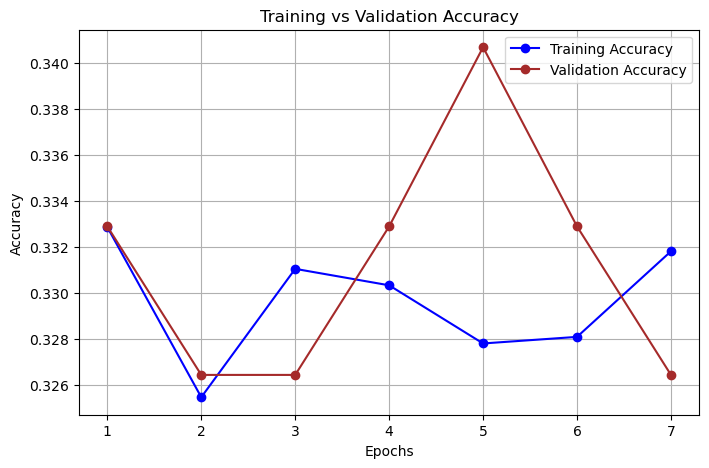

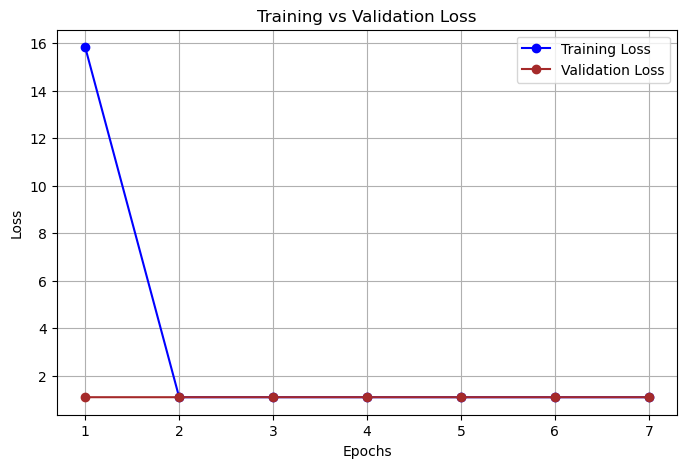

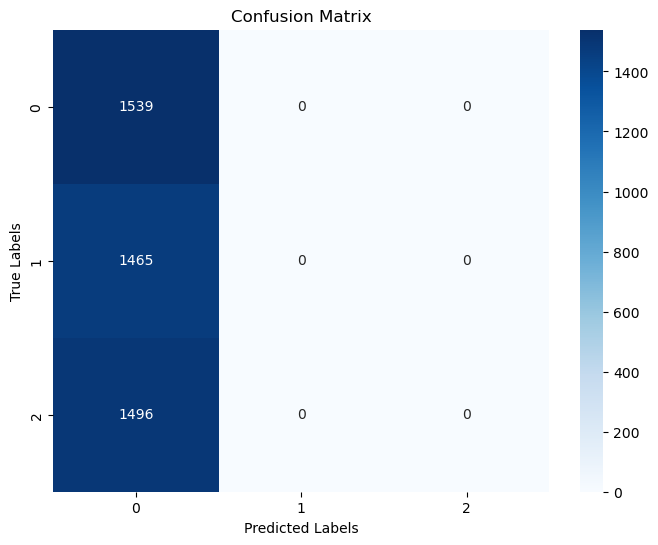

Precision: 0.1140
Recall: 0.3333
F1-score: 0.1699


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


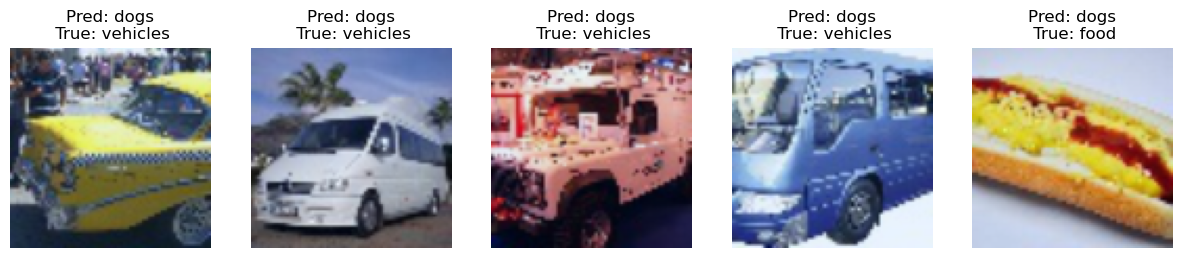

In [26]:
model11, history11 = experiment(num_classes = num_classes, init_type='xavier', optimizer_name = 'Adam', batch_size = 64, num_epochs = 7)
get_model_performance(model11, history11)

**Part 1 - Step 2 - Parameter Tuning Case 12**  
Weight init = 'xavier' / Optimizer = 'Adam' / Batch size = 128

--- VGG16-C with init = xavier, optimizer = Adam, batch_size = 128 ---
Epoch [1 of 7]: Train Loss: 6.6836, Train Acc: 0.3375 | Val Loss: 1.0987, Val Acc: 0.3407
Epoch [2 of 7]: Train Loss: 1.7247, Train Acc: 0.3322 | Val Loss: 1.0988, Val Acc: 0.3264
Epoch [3 of 7]: Train Loss: 1.0995, Train Acc: 0.3340 | Val Loss: 1.0996, Val Acc: 0.3264
Epoch [4 of 7]: Train Loss: 1.0992, Train Acc: 0.3321 | Val Loss: 1.0985, Val Acc: 0.3407
Epoch [5 of 7]: Train Loss: 1.0992, Train Acc: 0.3342 | Val Loss: 1.0986, Val Acc: 0.3407
Epoch [6 of 7]: Train Loss: 1.0989, Train Acc: 0.3330 | Val Loss: 1.0987, Val Acc: 0.3264
Epoch [7 of 7]: Train Loss: 1.0989, Train Acc: 0.3317 | Val Loss: 1.0990, Val Acc: 0.3264
Early stopping
Closing TensorBoard writer for runs/VGG16C_xavier_Adam_128
Test Loss: 1.0984, Test Accuracy: 0.3420


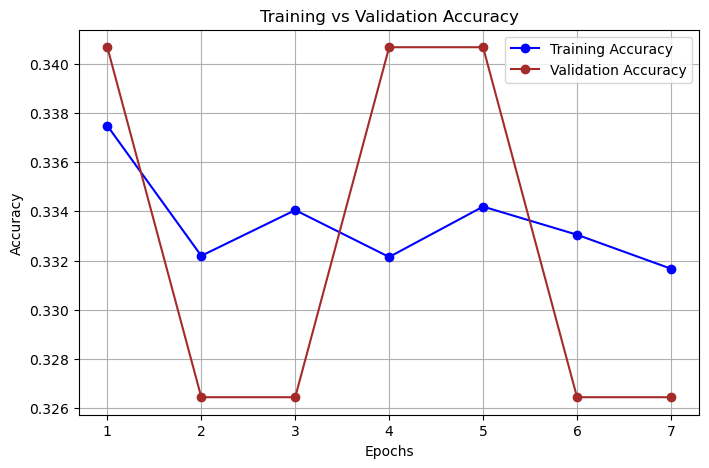

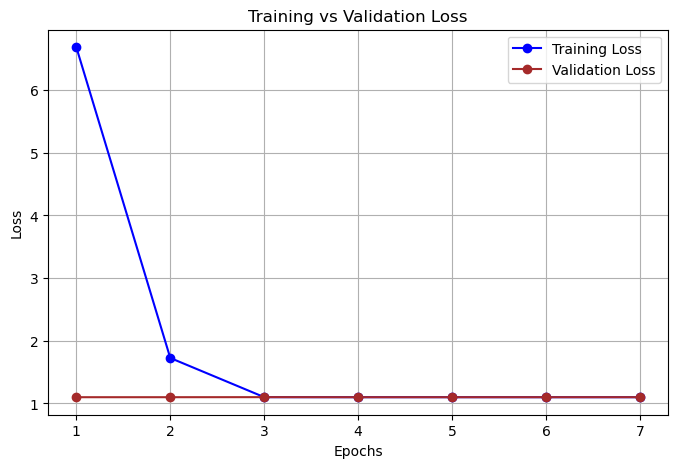

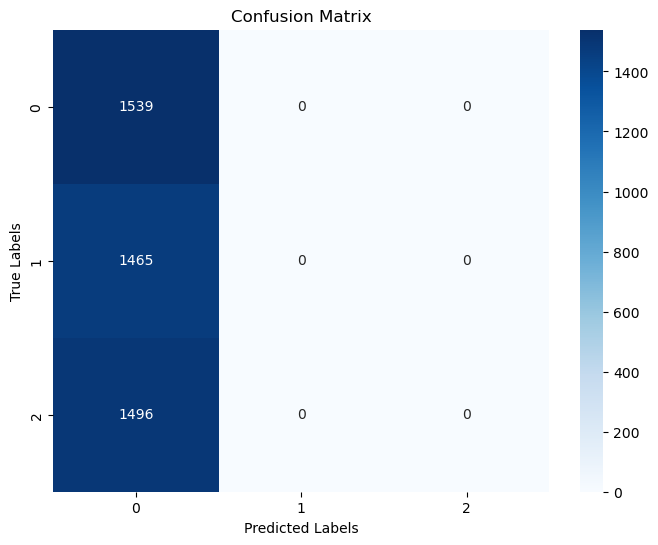

Precision: 0.1140
Recall: 0.3333
F1-score: 0.1699


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


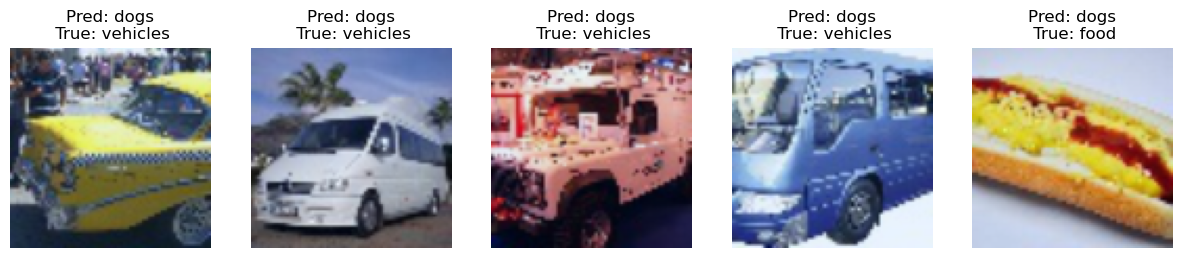

In [27]:
model12, history12 = experiment(num_classes = num_classes, init_type='xavier', optimizer_name = 'Adam', batch_size = 128, num_epochs = 7)
get_model_performance(model12, history12)

**Part 1 - Step 2 - Save the weights of the trained network**

After all cases of the VGG model, I saved the case with weight initialization = 'he', Optimizer = 'SGD', and batch size = 64. This can show 91% accuracy for testing.

In [64]:
torch.save(model3.state_dict(), "vgg_best_weights.pth")
print("Model saved")

Model saved


## Step 3: Implementing ResNet

**Part 1 - Step 3 - Implementing residual blocks of ResNet / Assemble the ResNet-18 architecture / Train the ResNet-18 model / Apply regularization techniques.**  

- The ResNet18 class defines a deep convolutional neural network using residual connections to improve training efficiency and accuracy. It consists of an initial 7x7 convolutional layer to contain batch normalization, ReLU activation, and max pooling to downsample the input. The network applies four sequential layers of residual blocks that maintain information flow through skip connections, each consisting of two 3x3 convolutional layers, batch normalization, ReLU activation, and optional downsampling. Finally, an adaptive average pooling layer reduces feature map dimensions before the final fully connected classification layer while producing predictions based on the learned features. The make_layer() function constructs the residual blocks dynamically while maintaining the correct number of channels. The forward() method sequentially processes input through these layers. And it leverage residual learning to enhance gradient flow and training stability.
- I used Dropout with value 0.5 which can mean that 50% of the neurons in the fully connected layers are randomly dropped during training to prevent overfitting. dropout mechanism is included within the residual blocks and before the fully connected layer to prevent overfitting
- StepLR is selected as a scheduler for reducing the learning rate by defining gamma with 0.5 and step size with 5
- I can apply 3 methods for overfitting and regularization. Firstly, early stopping has been tried. It can make the model to stop when the model has no more progresses in the defined count. On the next step, Batch Normalization like BatchNorm2d can be seen in the Resnet class. Finally, a parameter like weight decay in optim library can prevent overfitting while applying L2 regularization because this resnet is using almost same training and testing function.

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None, dropout_val = 0.5):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride=stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.dropout = nn.Dropout(p = dropout_val)

    def forward(self, x):
        identity = x
        
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out, inplace = True)
        out = self.dropout(out)
        out = self.conv2(out)

        out = self.bn2(out)
        out += identity
        out = F.relu(out, inplace = True)

        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes, dropout_size = 0.5):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.dropout_size = dropout_size

        self.conv1 = nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride = 2, padding = 1)

        self.layer1 = self.make_layer(64, 2, stride = 1, dropout_size = self.dropout_size)
        self.layer2 = self.make_layer(128, 2, stride = 2, dropout_size = self.dropout_size)
        self.layer3 = self.make_layer(256, 2, stride = 2, dropout_size = self.dropout_size)
        self.layer4 = self.make_layer(512, 2, stride = 2, dropout_size = self.dropout_size)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p = dropout_size)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, out_channels, blocks, stride, dropout_size):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels, kernel_size = 1, stride = stride, bias = False), nn.BatchNorm2d(out_channels))

        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, downsample, dropout_val = dropout_size))

        self.in_channels = out_channels

        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        return x


def experiment_for_resnet(num_classes, optimizer_name='SGD', batch_size = 32, num_epochs=10):
    print(f"--- ResNet18 with optimizer = {optimizer_name}, batch_size = {batch_size} ---")
    
    model = ResNet18(num_classes=num_classes, dropout_size = 0.5).to(device)
    optimizer = optimizers[optimizer_name](model.parameters())
    scheduler = StepLR(optimizer, step_size = 5, gamma = 0.5)    
    model, history = train_model(model, train_loader, val_loader, scheduler = scheduler, num_epochs = num_epochs, patience = 3, 
                                 optim = optimizer, optim_str=optimizer_name, batch_size = batch_size)
    test_loss, test_acc = validate(model, test_loader, nn.CrossEntropyLoss())
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    return model, history

**Part 1 - Step 3 - Train the ResNet-18 model / Save the best model for Resnet**  
Optimizer = 'SGD' / Batch size = 64


- The more I try epochs, accuracy for training and validation tend to increase.
- The more I try epochs, loss for training and validation tend to decrease.
- This case classifies all of the classes well evenly.
- The model performs very well with high precision and recall indicating that it effectively classifies positive cases while minimizing both false positives and false negatives.
- Like the fourth case, when the image has two more objects, it is not easy to classify it correctly.
- The best weights are saved as a pth file

--- ResNet18 with optimizer = SGD, batch_size = 64 ---
Epoch [1 of 7]: Train Loss: 0.5309, Train Acc: 0.7810 | Val Loss: 0.5101, Val Acc: 0.8140
Epoch [2 of 7]: Train Loss: 0.3584, Train Acc: 0.8658 | Val Loss: 0.4411, Val Acc: 0.8471
Epoch [3 of 7]: Train Loss: 0.3114, Train Acc: 0.8820 | Val Loss: 0.3531, Val Acc: 0.8800
Epoch [4 of 7]: Train Loss: 0.2845, Train Acc: 0.8938 | Val Loss: 0.3007, Val Acc: 0.8913
Epoch [5 of 7]: Train Loss: 0.2578, Train Acc: 0.9032 | Val Loss: 0.3106, Val Acc: 0.8891
Epoch [6 of 7]: Train Loss: 0.2128, Train Acc: 0.9209 | Val Loss: 0.2140, Val Acc: 0.9278
Epoch [7 of 7]: Train Loss: 0.2083, Train Acc: 0.9224 | Val Loss: 0.2326, Val Acc: 0.9127
Closing TensorBoard writer for runs/VGG16C_he_SGD_64
Test Loss: 0.2194, Test Accuracy: 0.9164
Model saved


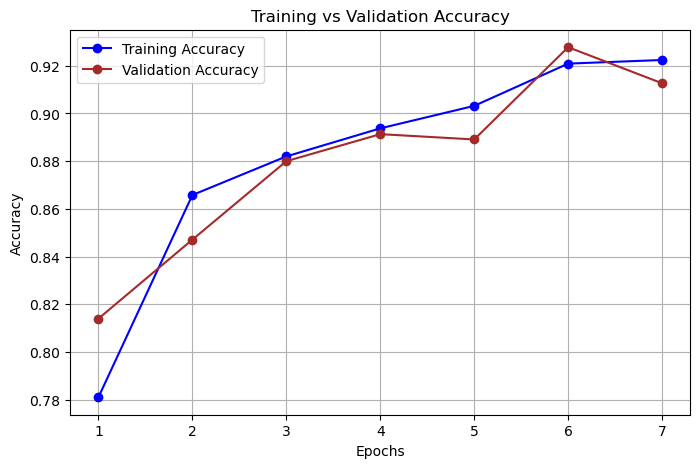

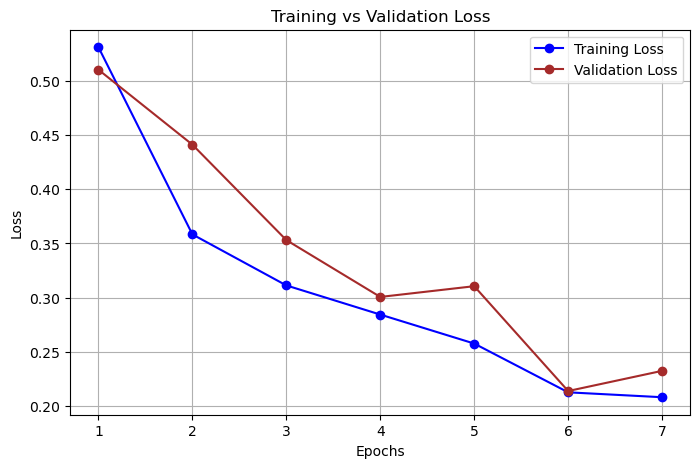

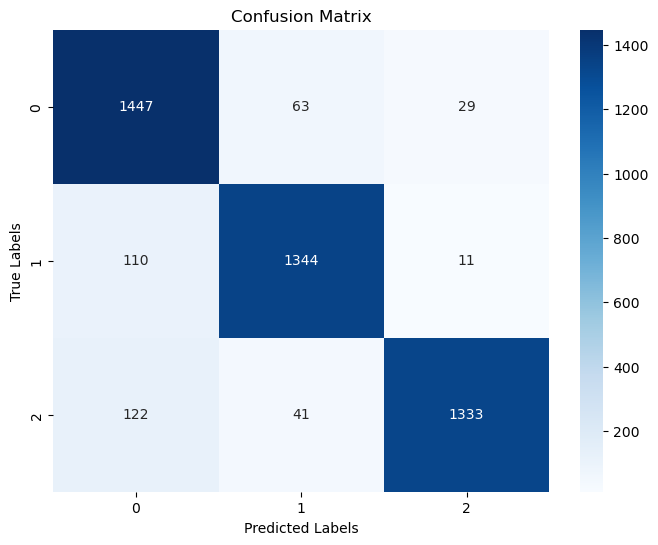

Precision: 0.9203
Recall: 0.9162
F1-score: 0.9171


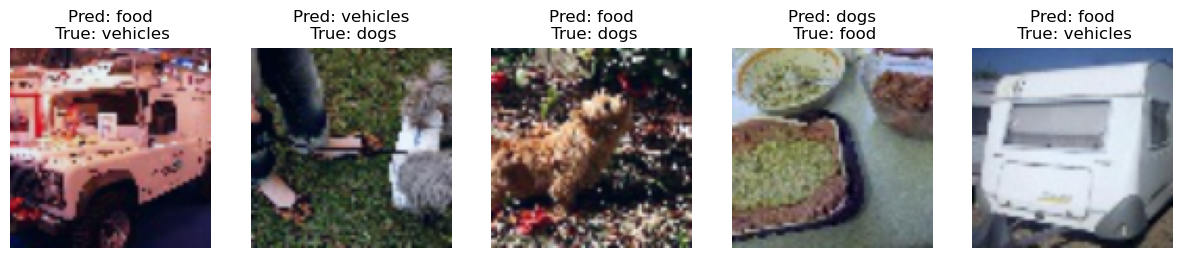

In [60]:
model_resnet, history_resnet = experiment_for_resnet(num_classes = num_classes, optimizer_name = 'SGD', batch_size = 64, num_epochs = 7)
torch.save(model_resnet.state_dict(), "resnet18_best_weights.pth")
print("Model saved")

get_model_performance(model_resnet, history_resnet)

**Part 1 - Step 3 - Comparing performances between Resnet and VGG by plot visualization**

- The graphs compare the training and validation performance of ResNet-18 and VGG-16 over seven epochs. In the training accuracy plot, ResNet-18 starts with a higher accuracy and consistently outperforms VGG-16 and reaching over 90%, while VGG-16 lags behind but still improves gradually. The validation accuracy follows a similar trend, with ResNet-18 achieving higher accuracy across all epochs, peaking around 92%, whereas VGG-16 struggles more, showing fluctuations.
- The training loss graph reveals a notable difference: VGG-16 starts with an abnormally high loss but rapidly drops to near zero after the second epoch, which may indicate an issue in loss scaling or instability in early training. Meanwhile, ResNet-18 maintains a more stable and reasonable loss trajectory. The validation loss further highlights ResNet-18's superior generalization, as it steadily decreases, while VGG-16's loss remains relatively higher and inconsistent, suggesting weaker convergence.

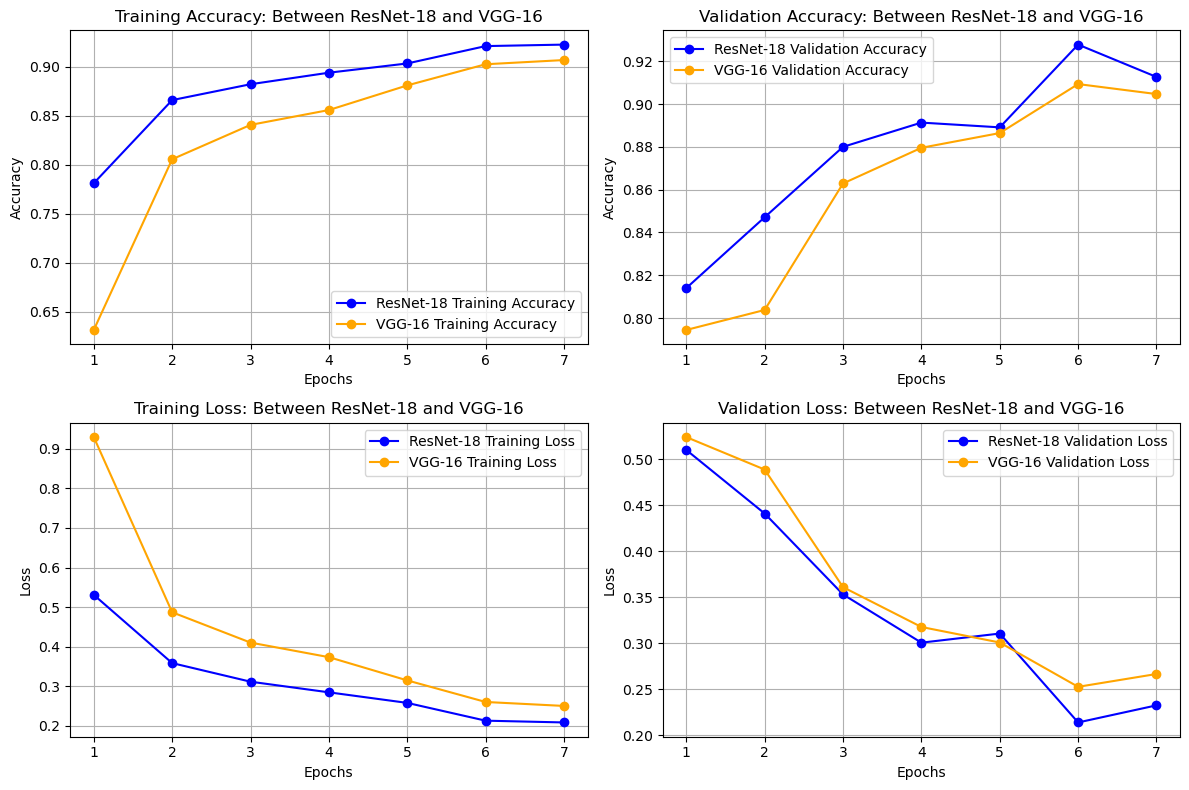

In [63]:
vgg_train_acc = history3['train_acc']
vgg_val_acc = history3['val_acc']
vgg_train_loss = history3['train_loss']
vgg_val_loss = history3['val_loss']
resnet_train_acc = history_resnet['train_acc']
resnet_val_acc = history_resnet['val_acc']
resnet_train_loss = history_resnet['train_loss']
resnet_val_loss = history_resnet['val_loss']

min_epochs = min(len(vgg_train_acc), len(resnet_train_acc))

vgg_train_acc = vgg_train_acc[:min_epochs]
vgg_val_acc = vgg_val_acc[:min_epochs]
vgg_train_loss = vgg_train_loss[:min_epochs]
vgg_val_loss = vgg_val_loss[:min_epochs]
resnet_train_acc = resnet_train_acc[:min_epochs]
resnet_val_acc = resnet_val_acc[:min_epochs]
resnet_train_loss = resnet_train_loss[:min_epochs]
resnet_val_loss = resnet_val_loss[:min_epochs]


epochs = range(1, min_epochs + 1)

# --------------------------------------------------------------------------------------------------------------------------------------------------------

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, resnet_train_acc, 'bo-', label = "ResNet-18 Training Accuracy")
plt.plot(epochs, vgg_train_acc, 'o-', color = 'orange', label = "VGG-16 Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy: Between ResNet-18 and VGG-16")
plt.legend()
plt.grid()
plt.xticks(epochs)

# --------------------------------------------------------------------------------------------------------------------------------------------------------

plt.subplot(2, 2, 2)
plt.plot(epochs, resnet_val_acc, 'bo-', label = "ResNet-18 Validation Accuracy")
plt.plot(epochs, vgg_val_acc, 'o-', color = 'orange', label = "VGG-16 Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy: Between ResNet-18 and VGG-16")
plt.legend()
plt.grid()
plt.xticks(epochs)

# --------------------------------------------------------------------------------------------------------------------------------------------------------

plt.subplot(2, 2, 3)
plt.plot(epochs, resnet_train_loss, 'bo-', label = "ResNet-18 Training Loss")
plt.plot(epochs, vgg_train_loss, 'o-', color = 'orange', label = "VGG-16 Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss: Between ResNet-18 and VGG-16")
plt.legend()
plt.grid()
plt.xticks(epochs)

# --------------------------------------------------------------------------------------------------------------------------------------------------------

plt.subplot(2, 2, 4)
plt.plot(epochs, resnet_val_loss, 'bo-', label = "ResNet-18 Validation Loss")
plt.plot(epochs, vgg_val_loss, 'o-', color = 'orange', label = "VGG-16 Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss: Between ResNet-18 and VGG-16")
plt.legend()
plt.grid()
plt.xticks(epochs)

plt.tight_layout()
plt.show()


## Step 4: Discussion and Tensorboard with Resnet and VGG

<img src="Tensorboard_accuracy.png" alt="Sample Image" width="1100">
<img src="Tensorboard_loss.png" alt="Sample Image" width="1100">

1. Explain the theoretical concepts behind VGG and ResNet.

- VGG and ResNet represent two distinct theoretical approaches to deep convolutional network design that have both significantly influenced the field.
- VGG uses a uniform design with repeated small convolutional filters. This simplifies the network while stacking layers to achieve a large receptive field without excess parameters. This structure allows it to progressively extract more complex features from basic edges to complicated patterns enhancing the performance in object recognition and other visual tasks.
- On the other hand, ResNet introduces the concept of residual learning to learn a residual function relative to the input instead of directly approximating the desired mapping. ResNet fix the vanishing gradient problem abd enables the training of networks with many layers by incorporating skip connections which allow the input to bypass one or more layers. This structure means that if the additional layers don't provide a benefit. Ultimately, while VGG emphasizes architectural simplicity and depth to achieve robust feature hierarchies, ResNet utilize residual connections to streamline the optimization process and improve gradient flow and makes it feasible to train much deeper networks without compromising performance.

2. Discuss the impact of regularization and optimization techniques.

- Batch Normalization helps by standardizing the inputs of each layer during training. This not only reduces the internal changes in data distribution but also allows to use higher learning rates which can lead to faster and more stable convergence. It even adds a little bit of regularization.

- Early Stopping monitors some changes on the validation performance as training progresses. When I notice that the model stops improving, I can pause the training process. This approach helps prevent overfitting and saves time by avoiding unnecessary training.

- L2 Regularization works by penalizing large weights in the model. It helps to keep the model simpler and more generalizable by discouraging overly large values. This makes the optimization process smoother and usually improve performance on unfamilar data.

3. Analyze the results, including all required graphs and metrics.

Both models improved in accuracy over time. But ResNet 18 consistently maintained an edge and reached a training accuracy of over 91% and validation accuracy above 92%, while VGG-16 slightly lagged behind at around 90% validation accuracy. The training and validation loss curves  confirm ResNet18’s superiority because it indicated a more stable and lower loss trajectory and suggested better convergence. While VGG16 also improved, the loss was initially higher and remained slightly above ResNet18’s throughout the process. The superior performance of ResNet18 can come from residual connections, which help mitigate the vanishing gradient problem and allow deeper networks to learn efficiently. These connections ensure smoother gradient flow which can lead to better optimization and generalization. On the other hand, VGG16 to have a deeper plain network is more likely to overfitting and slow convergence.

4. Summarize your findings and discuss the advantages of residual connections.

Residual connections in ResNet allow information to bypass one or more layers, which significantly improves gradient flow and alleviates the vanishing gradient problem. This design lets the network learn only the necessary modifications to the input rather than the entire transformation. And it simplifies optimization and ensures that adding extra layers doesn't degrade performance. It enables the construction of much deeper and more effective models.

5. References.

- Stanford CS231n(Lecture 9 | CNN Architectures)
- Very Deep Convolutional Networks for Large-Scale Image Recognition (Authored by Karen Simonyan and Andrew Zisserman)
- VGG Wikipedia (https://en.wikipedia.org/wiki/VGG)
- VGG-Net Architecture Explained (Geeks for Geeks)